# Reinforcement Learning with Imitation Learning and Self-Play

The complete workflow for training a Lunar Lander agent using:
1. Expert DQN training
2. Expert trajectory generation
3. Behavioral Cloning
4. DAgger (Dataset Aggregation)
5. Self-Play with Previous Version
6. Comprehensive evaluation

We'll be using the LunarLander-v3 environment from Gymnasium.

### Note: Restart the session if the dependencies are not loaded, always need to restart after the installing all the dependencies

## 1. Setup and Installation

In [2]:
!apt-get install -y swig

!git clone https://github.com/openai/box2d-py
%cd box2d-py
!pip install -e .

%cd ..
!pip install gymnasium[box2d] --no-deps

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
fatal: destination path 'box2d-py' already exists and is not an empty directory.
/content/box2d-py
Obtaining file:///content/box2d-py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8
  Running setup.py develop for box2d-py
/content


In [3]:
!pip install torch matplotlib numpy tqdm

In [4]:
import os
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import pickle
from collections import namedtuple, deque
from itertools import count
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs("models", exist_ok=True)

Using device: cuda


## 2. Define DQN Architecture

First, let's define the neural network architecture for our DQN agent.

In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## 3. DQN Expert Training

Here we'll train our expert DQN model on the LunarLander environment.

In [6]:
# parameters
num_episodes = 800
batch_size = 128
GAMMA = 0.99
LR = 1e-4
TAU = 0.005

EPSILON = 1.0  # start with full exploration
EPSILON_MIN = 0.01  # minimum value
EPSILON_DECAY = 0.995  # decay factor per episode

reward_list = []
episode_durations = []

# transition namedtuple to store the trajectories
Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])

# Replay Memory Buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return (
            random.sample(self.memory, batch_size)
            if batch_size < len(self.memory)
            else self.memory
        )

    def __len__(self):
        return len(self.memory)

In [7]:
# initialize the environment
env = gym.make("LunarLander-v3")

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

replay_memory = ReplayMemory(10000)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return torch.tensor(
            [[env.action_space.sample()]], dtype=torch.long, device=device
        )
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)  # Exploit (best action)

optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

In [8]:
# training the expert DQN model
print("Training Expert DQN...")

for episode in tqdm(range(num_episodes), desc="Training Episodes"):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state, EPSILON)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        done = terminated or truncated
        reward = torch.tensor([reward], device=device)
        next_state = torch.tensor(
            next_state, dtype=torch.float32, device=device
        ).unsqueeze(0)
        replay_memory.push(state, action, next_state, reward, done)

        state = next_state
        total_reward += reward.item()

        if len(replay_memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            states, actions, next_states, rewards, dones = zip(*transitions)

            states_batch = torch.cat(states)
            next_states_batch = torch.cat(next_states)
            actions_batch = torch.cat(actions)
            rewards = torch.tensor(rewards, device=device)
            dones = torch.tensor(dones, device=device)

            q_target = (
                GAMMA * target_net(next_states_batch).detach().max(1)[0] * ~dones
                + rewards
            )
            q_policy = policy_net(states_batch).gather(1, actions_batch)

            # calculating the Huber loss
            loss = criterion(q_policy, q_target.unsqueeze(1))

            # optimize the model
            optimizer.zero_grad()
            loss.backward()

            # in-place gradient clipping to stabilize training
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

            optimizer.step()

        # update target network
        for target_param, main_param in zip(
            target_net.parameters(), policy_net.parameters()
        ):
            target_param.data.copy_(
                TAU * main_param.data + (1 - TAU) * target_param.data
            )

        if done:
            episode_durations.append(t + 1)
            reward_list.append(total_reward)
            break

    # Decay epsilon
    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

    if episode % 10 == 0:
        avg_reward = np.mean(reward_list[-10:]) if reward_list else 0
        print(f"Episode {episode}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {EPSILON:.2f}")

torch.save(policy_net.state_dict(), "models/dqn_lunar_lander.pth")
print("Expert DQN model saved successfully!")

Training Expert DQN...


Training Episodes:   0%|          | 0/800 [00:00<?, ?it/s]

Episode 0/800, Avg Reward: -279.07, Epsilon: 0.99
Episode 10/800, Avg Reward: -179.92, Epsilon: 0.95
Episode 20/800, Avg Reward: -154.47, Epsilon: 0.90
Episode 30/800, Avg Reward: -115.84, Epsilon: 0.86
Episode 40/800, Avg Reward: -107.47, Epsilon: 0.81
Episode 50/800, Avg Reward: -90.19, Epsilon: 0.77
Episode 60/800, Avg Reward: -99.06, Epsilon: 0.74
Episode 70/800, Avg Reward: -65.58, Epsilon: 0.70
Episode 80/800, Avg Reward: -64.65, Epsilon: 0.67
Episode 90/800, Avg Reward: -54.00, Epsilon: 0.63
Episode 100/800, Avg Reward: -73.52, Epsilon: 0.60
Episode 110/800, Avg Reward: -33.87, Epsilon: 0.57
Episode 120/800, Avg Reward: -18.35, Epsilon: 0.55
Episode 130/800, Avg Reward: -26.18, Epsilon: 0.52
Episode 140/800, Avg Reward: -52.31, Epsilon: 0.49
Episode 150/800, Avg Reward: -29.34, Epsilon: 0.47
Episode 160/800, Avg Reward: -16.37, Epsilon: 0.45
Episode 170/800, Avg Reward: 1.18, Epsilon: 0.42
Episode 180/800, Avg Reward: 7.44, Epsilon: 0.40
Episode 190/800, Avg Reward: -13.51, Epsi

1. Reward Trend per Episode

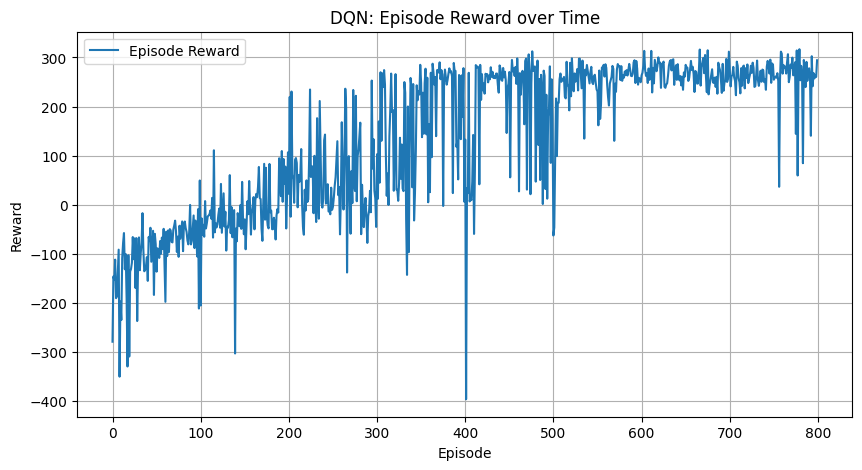

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(reward_list, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN: Episode Reward over Time")
plt.grid(True)
plt.legend()
plt.show()

2. Smoothed Reward Curve (Moving Average)

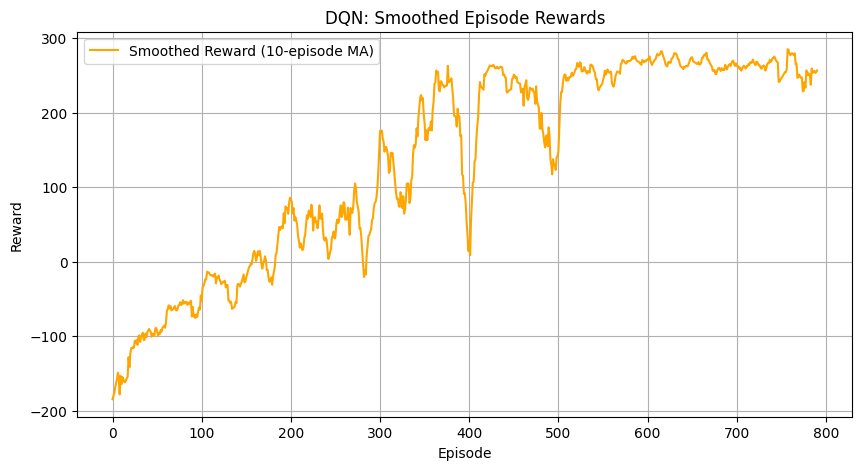

In [10]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(moving_average(reward_list), label="Smoothed Reward (10-episode MA)", color="orange")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN: Smoothed Episode Rewards")
plt.grid(True)
plt.legend()
plt.show()

3. Epsilon Decay Over Episodes

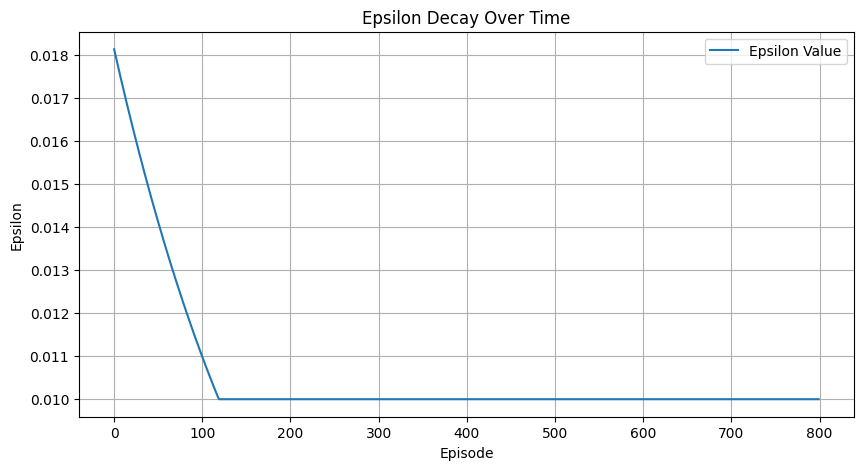

In [11]:
epsilons = [max(EPSILON_MIN, EPSILON * (EPSILON_DECAY ** i)) for i in range(num_episodes)]

plt.figure(figsize=(10, 5))
plt.plot(epsilons, label="Epsilon Value")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Time")
plt.grid(True)
plt.legend()
plt.show()

## 4. Generate Expert Trajectories

Let's generate and save expert trajectories using our trained DQN model.

In [12]:
# Saving the videos of the expert model stimulation
video_folder = "./dqn_expert_videos/"
os.makedirs(video_folder, exist_ok=True)

expert_policy = DQN(n_observations, n_actions).to(device)
expert_policy.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
expert_policy.eval()

# configuring environment for video recording
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder,
    episode_trigger=lambda ep: ep < 2,  # saving only first 2 episodes
    name_prefix="dqn_expert"
)

# expert trajectories
expert_trajectories = []
n_episodes = 30

print("Generating expert trajectories...")
for episode in range(n_episodes):
    state, _ = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    trajectory = {"obs": [], "actions": [], "rewards": []}
    total_reward = 0

    for t in count():
        with torch.no_grad():
            action = expert_policy(state_tensor).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)

        trajectory["obs"].append(state)
        trajectory["actions"].append(action)
        trajectory["rewards"].append(reward)

        total_reward += reward
        done = terminated or truncated
        if done:
            break

        state = next_state
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    expert_trajectories.append(trajectory)
    print(f"Episode {episode + 1}/{n_episodes} | Total reward: {total_reward:.2f}")

env.close()
print(f"Saved videos to: {video_folder}")

with open('expert_trajectories.pkl', 'wb') as f:
    pickle.dump(expert_trajectories, f)
print("Expert trajectories saved!")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/dqn_expert_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Generating expert trajectories...
Episode 1/30 | Total reward: 161.79
Episode 2/30 | Total reward: 282.03
Episode 3/30 | Total reward: 279.80
Episode 4/30 | Total reward: 290.86
Episode 5/30 | Total reward: 286.32
Episode 6/30 | Total reward: 258.52
Episode 7/30 | Total reward: 297.55
Episode 8/30 | Total reward: 247.71
Episode 9/30 | Total reward: 295.44
Episode 10/30 | Total reward: 277.13
Episode 11/30 | Total reward: 273.17
Episode 12/30 | Total reward: 254.26
Episode 13/30 | Total reward: 306.21
Episode 14/30 | Total reward: 181.64
Episode 15/30 | Total reward: 237.07
Episode 16/30 | Total reward: 258.01
Episode 17/30 | Total reward: 270.16
Episode 18/30 | Total reward: 293.65
Episode 19/30 | Total reward: 151.29
Episode 20/30 | Total reward: 283.33
Episode 21/30 | Total reward: 291.36
Episode 22/30 | Total reward: 257.03
Episode 23/30 | Total reward: 156.70
Episode 24/30 | Total reward: 275.93
Episode 25/30 | Total reward: 41.46
Episode 26/30 | Total reward: 282.70
Episode 27/30 

1. Total Reward per Expert Episode

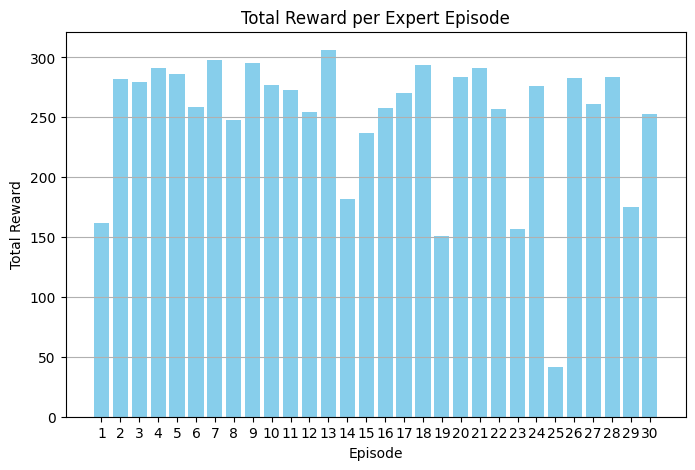

In [13]:
expert_rewards = [sum(traj["rewards"]) for traj in expert_trajectories]

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(expert_rewards) + 1), expert_rewards, color='skyblue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Expert Episode")
plt.xticks(range(1, len(expert_rewards) + 1))
plt.grid(axis='y')
plt.show()

2. Action Distribution Over Expert Trajectories

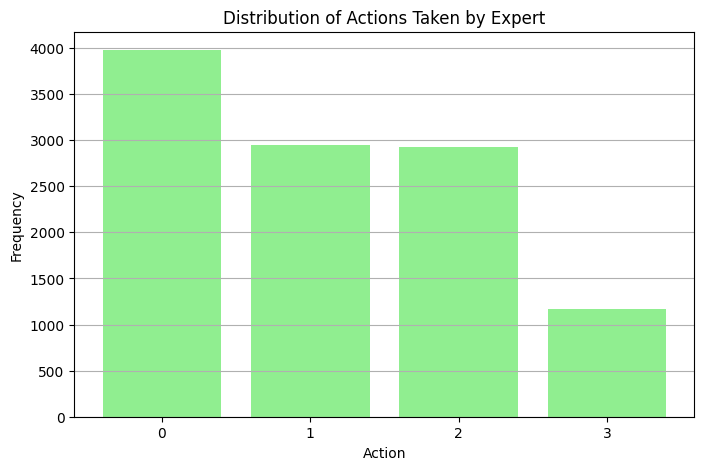

In [14]:
all_actions = [action for traj in expert_trajectories for action in traj["actions"]]
action_counts = [all_actions.count(a) for a in range(n_actions)]

plt.figure(figsize=(8, 5))
plt.bar(range(n_actions), action_counts, color='lightgreen')
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Distribution of Actions Taken by Expert")
plt.xticks(range(n_actions))
plt.grid(axis='y')
plt.show()

3. Cumulative Reward Curve for All Episodes

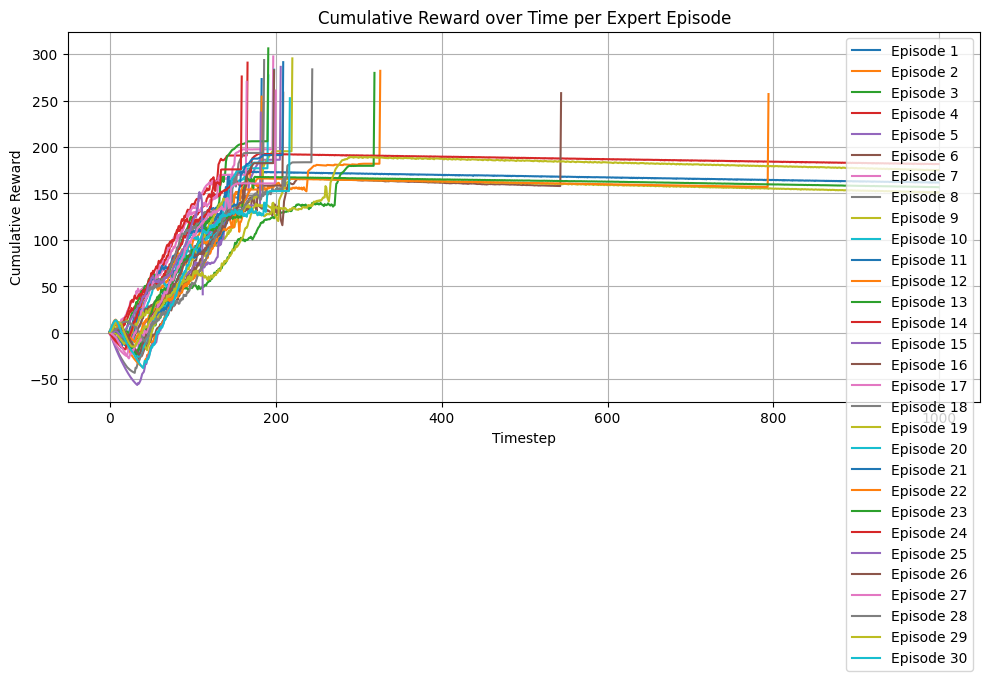

In [15]:
plt.figure(figsize=(10, 6))
for i, traj in enumerate(expert_trajectories):
    cum_reward = np.cumsum(traj["rewards"])
    plt.plot(cum_reward, label=f"Episode {i+1}")

plt.xlabel("Timestep")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Time per Expert Episode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4. Reward Density Distribution

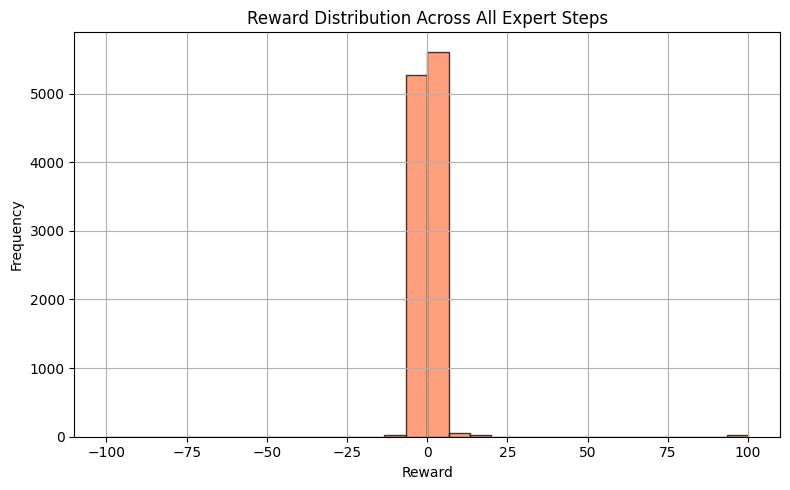

In [16]:
all_rewards = [r for traj in expert_trajectories for r in traj["rewards"]]

plt.figure(figsize=(8, 5))
plt.hist(all_rewards, bins=30, color="coral", edgecolor="black", alpha=0.75)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Across All Expert Steps")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Behavioral Cloning

Train a student model to mimic the expert's behavior.

In [17]:
with open('expert_trajectories.pkl', 'rb') as f:
    expert_trajectories = pickle.load(f)

loss_history = []

# Student Model (same architecture as DQN but fresh weights)
env = gym.make("LunarLander-v3")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

student_model = DQN(n_observations, n_actions).to(device)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# dataset from expert trajectories
states = []
actions = []
for trajectory in expert_trajectories:
    states.extend(trajectory['obs'])
    actions.extend(trajectory['actions'])

states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
actions = torch.tensor(actions, dtype=torch.long).to(device)

# Training loop
epochs = 200
batch_size = 64
dataset_size = len(states)

print("Training student model with Behavioral Cloning...")
for epoch in tqdm(range(epochs), desc="BC Training"):
    # shuffle data
    indices = torch.randperm(dataset_size)
    total_loss = 0.0
    batches = 0

    for start_idx in range(0, dataset_size, batch_size):
        # getting batch data acc to batch size and indices
        batch_indices = indices[start_idx:start_idx + batch_size]

        state_batch = states[batch_indices]
        action_batch = actions[batch_indices]

        # Forward pass
        logits = student_model(state_batch)
        loss = criterion(logits, action_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    avg_loss = total_loss / batches
    loss_history.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

torch.save(student_model.state_dict(), "models/imitation_model.pth")
print("Behavioral Cloning model saved successfully!")

Training student model with Behavioral Cloning...


BC Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 1.0082
Epoch 11/200, Loss: 0.5813
Epoch 21/200, Loss: 0.5002
Epoch 31/200, Loss: 0.4436
Epoch 41/200, Loss: 0.3804
Epoch 51/200, Loss: 0.3239
Epoch 61/200, Loss: 0.3097
Epoch 71/200, Loss: 0.2612
Epoch 81/200, Loss: 0.2434
Epoch 91/200, Loss: 0.2297
Epoch 101/200, Loss: 0.2218
Epoch 111/200, Loss: 0.1991
Epoch 121/200, Loss: 0.1993
Epoch 131/200, Loss: 0.1806
Epoch 141/200, Loss: 0.2240
Epoch 151/200, Loss: 0.1889
Epoch 161/200, Loss: 0.1945
Epoch 171/200, Loss: 0.1714
Epoch 181/200, Loss: 0.1662
Epoch 191/200, Loss: 0.1610
Behavioral Cloning model saved successfully!


1. Loss Curve During Behavioral Cloning

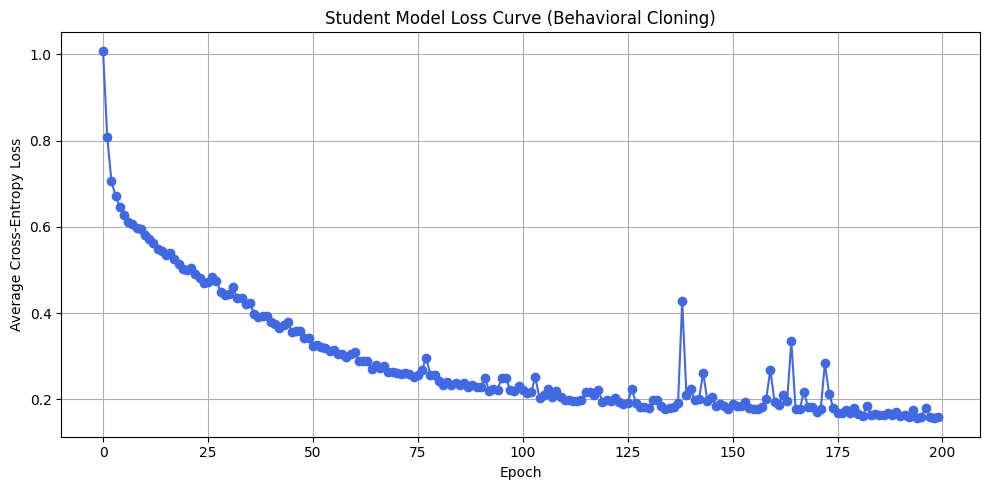

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, color='royalblue', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Student Model Loss Curve (Behavioral Cloning)")
plt.grid(True)
plt.tight_layout()
plt.show()

2. Student vs Expert Action Match (Accuracy Estimate)

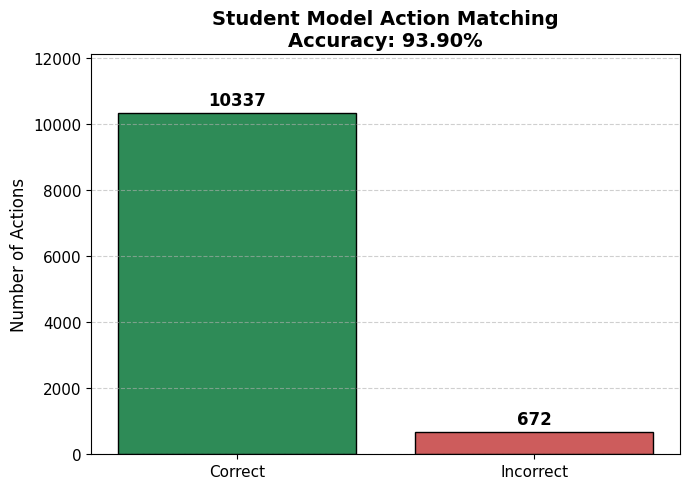

In [19]:
with torch.no_grad():
    student_logits = student_model(states)
    student_preds = student_logits.argmax(dim=1)

    correct = (student_preds == actions).sum().item()
    total = len(actions)
    incorrect = total - correct
    accuracy = correct / total * 100

# Enhanced plot
fig, ax = plt.subplots(figsize=(7, 5))

bars = ax.bar(["Correct", "Incorrect"], [correct, incorrect], color=["seagreen", "indianred"], edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + total * 0.01, f"{yval}", ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title(f"Student Model Action Matching\nAccuracy: {accuracy:.2f}%", fontsize=14, weight='bold')
ax.set_ylabel("Number of Actions", fontsize=12)
ax.tick_params(axis='both', labelsize=11)
ax.set_ylim(0, total * 1.1)  # add some space above bars
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

3. Action Distribution: Expert vs Student

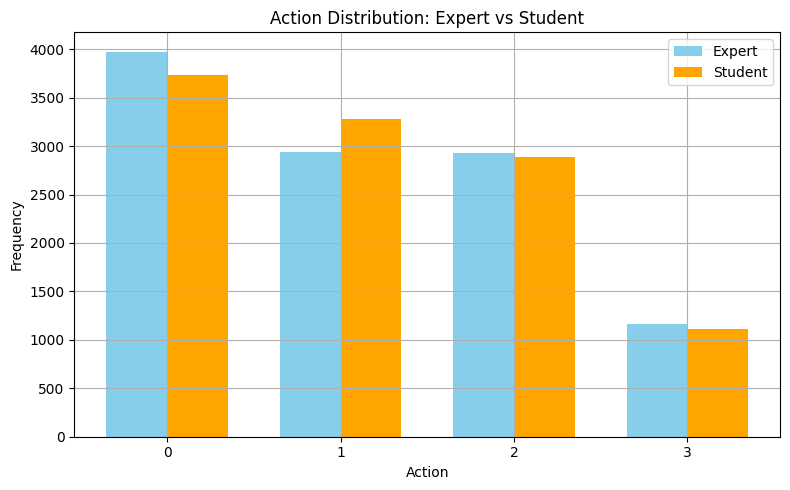

In [20]:
# Expert actions
expert_action_counts = [actions.cpu().tolist().count(i) for i in range(n_actions)]

# Student actions
student_action_counts = [student_preds.cpu().tolist().count(i) for i in range(n_actions)]

x = range(n_actions)
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, expert_action_counts, width=bar_width, label='Expert', color='skyblue')
plt.bar([i + bar_width for i in x], student_action_counts, width=bar_width, label='Student', color='orange')
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution: Expert vs Student")
plt.xticks([i + bar_width/2 for i in x], x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. DAgger (Dataset Aggregation)

Use DAgger to improve the student model by aggregating additional expert-labeled data.

In [ ]:
env = gym.make("LunarLander-v3")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Expert
expert_model = DQN(n_observations, n_actions).to(device)
expert_model.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
expert_model.eval()

# Student (initially from behavioral cloning)
student_model = DQN(n_observations, n_actions).to(device)
student_model.load_state_dict(torch.load("models/imitation_model.pth", map_location=device))

if not os.path.exists('dagger_dataset.pkl'):
    # Create an empty dictionary and save it if the file doesn't exist
    dataset = {'states': [], 'actions': []} 
    with open('dagger_dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)
    print("Created a new dagger_dataset.pkl file")

# Now you can load the file (it will be empty if it was newly created)
with open('dagger_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    print("Loaded DAgger dataset")

# DAgger parameters
n_dagger_iterations = 15
n_episodes_per_iteration = 10
epochs_per_iteration = 20
batch_size = 64

optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Loaded DAgger dataset


In [ ]:
losses_per_iteration = []
dataset_sizes = []

# DAgger training loop
print("Starting DAgger training...")
for dagger_iter in range(n_dagger_iterations):
    print(f"\nDAgger Iteration {dagger_iter+1}/{n_dagger_iterations}")

    # Collect data with student policy, but label with expert
    for episode in tqdm(range(n_episodes_per_iteration), desc="Collecting data"):
        state, _ = env.reset()
        done = False

        while not done:
            # Student collects state
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Student takes action
            with torch.no_grad():
                student_action = student_model(state_tensor).argmax(dim=1).item()

            # Expert labels the state
            with torch.no_grad():
                expert_action = expert_model(state_tensor).argmax(dim=1).item()

            # Add to dataset with expert label
            dataset['states'].append(state)
            dataset['actions'].append(expert_action)

            # Execute student's action to get next state
            next_state, _, terminated, truncated, _ = env.step(student_action)
            done = terminated or truncated
            state = next_state

    # Convert to tensors
    states = torch.tensor(np.array(dataset['states']), dtype=torch.float32).to(device)
    actions = torch.tensor(dataset['actions'], dtype=torch.long).to(device)

    # Train student on aggregated dataset
    dataset_size = len(states)
    print(f"Training on aggregated dataset of size {dataset_size}...")
    dataset_sizes.append(dataset_size)

    avg_epoch_losses = []

    for epoch in tqdm(range(epochs_per_iteration), desc="Training"):
        # Shuffle data
        indices = torch.randperm(dataset_size)
        total_loss = 0.0
        batches = 0

        for start_idx in range(0, dataset_size, batch_size):
            # Get batch indices
            batch_indices = indices[start_idx:start_idx + batch_size]

            # Get batch data
            state_batch = states[batch_indices]
            action_batch = actions[batch_indices]

            # Forward pass
            logits = student_model(state_batch)
            loss = criterion(logits, action_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batches += 1

        avg_loss = total_loss / batches
        avg_epoch_losses.append(avg_loss)

        if epoch % 5 == 0:
            avg_loss = total_loss / batches
            print(f"  Epoch {epoch+1}/{epochs_per_iteration}, Loss: {avg_loss:.4f}")

    losses_per_iteration.append(avg_epoch_losses)

    # Save the updated model
    torch.save(student_model.state_dict(), f"models/dagger_model_iter{dagger_iter+1}.pth")

    # Save the dataset
    with open('dagger_dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

print("DAgger training complete!")

Starting DAgger training...

DAgger Iteration 1/15


Training on aggregated dataset of size 38369...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 1.4781
  Epoch 6/20, Loss: 0.6633
  Epoch 11/20, Loss: 0.6145
  Epoch 16/20, Loss: 0.5808

DAgger Iteration 2/15


Training on aggregated dataset of size 42716...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.5729
  Epoch 6/20, Loss: 0.5454
  Epoch 11/20, Loss: 0.5223
  Epoch 16/20, Loss: 0.5053

DAgger Iteration 3/15


Training on aggregated dataset of size 44712...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.4921
  Epoch 6/20, Loss: 0.4743
  Epoch 11/20, Loss: 0.4671
  Epoch 16/20, Loss: 0.4533

DAgger Iteration 4/15


Training on aggregated dataset of size 47830...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.4522
  Epoch 6/20, Loss: 0.4325
  Epoch 11/20, Loss: 0.4253
  Epoch 16/20, Loss: 0.4180

DAgger Iteration 5/15


Training on aggregated dataset of size 49862...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.4224
  Epoch 6/20, Loss: 0.4086
  Epoch 11/20, Loss: 0.4016
  Epoch 16/20, Loss: 0.3975

DAgger Iteration 6/15


Training on aggregated dataset of size 52235...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.4040
  Epoch 6/20, Loss: 0.3953
  Epoch 11/20, Loss: 0.3883
  Epoch 16/20, Loss: 0.3857

DAgger Iteration 7/15


Training on aggregated dataset of size 55042...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3877
  Epoch 6/20, Loss: 0.3725
  Epoch 11/20, Loss: 0.3684
  Epoch 16/20, Loss: 0.3638

DAgger Iteration 8/15


Training on aggregated dataset of size 58761...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3668
  Epoch 6/20, Loss: 0.3539
  Epoch 11/20, Loss: 0.3517
  Epoch 16/20, Loss: 0.3470

DAgger Iteration 9/15


Training on aggregated dataset of size 60709...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3444
  Epoch 6/20, Loss: 0.3413
  Epoch 11/20, Loss: 0.3390
  Epoch 16/20, Loss: 0.3339

DAgger Iteration 10/15


Training on aggregated dataset of size 63817...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3391
  Epoch 6/20, Loss: 0.3301
  Epoch 11/20, Loss: 0.3263
  Epoch 16/20, Loss: 0.3232

DAgger Iteration 11/15


Training on aggregated dataset of size 66998...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3206
  Epoch 6/20, Loss: 0.3177
  Epoch 11/20, Loss: 0.3125
  Epoch 16/20, Loss: 0.3097

DAgger Iteration 12/15


Training on aggregated dataset of size 69846...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3123
  Epoch 6/20, Loss: 0.3073
  Epoch 11/20, Loss: 0.3055
  Epoch 16/20, Loss: 0.3049

DAgger Iteration 13/15


Training on aggregated dataset of size 72856...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.3015
  Epoch 6/20, Loss: 0.2985
  Epoch 11/20, Loss: 0.2957
  Epoch 16/20, Loss: 0.2925

DAgger Iteration 14/15


Training on aggregated dataset of size 75959...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.2931
  Epoch 6/20, Loss: 0.2888
  Epoch 11/20, Loss: 0.2897
  Epoch 16/20, Loss: 0.2840

DAgger Iteration 15/15


Training on aggregated dataset of size 79715...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

  Epoch 1/20, Loss: 0.2834
  Epoch 6/20, Loss: 0.2828
  Epoch 11/20, Loss: 0.2782
  Epoch 16/20, Loss: 0.2747
DAgger training complete!


Plot 1: Loss curves

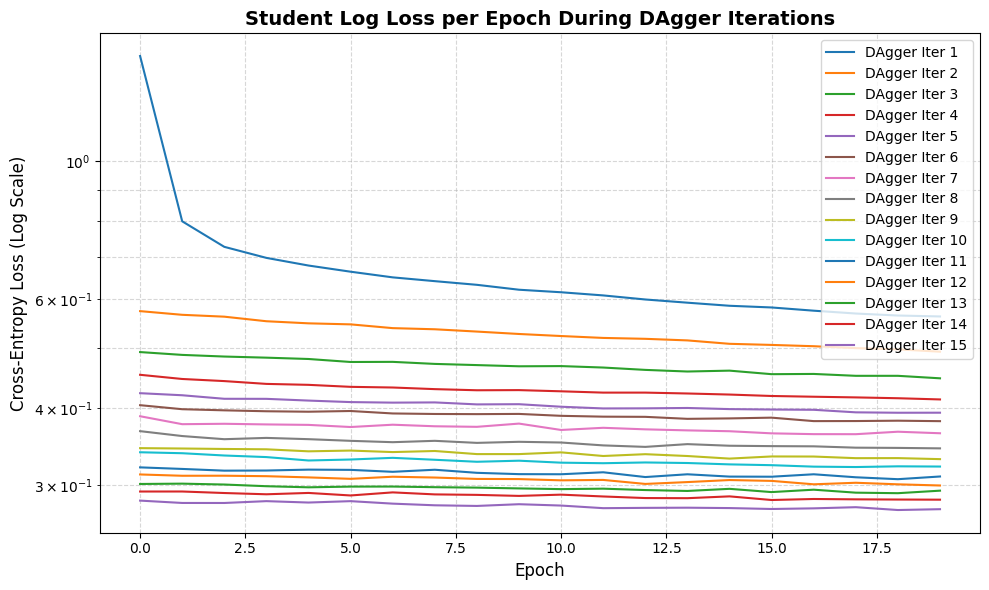

In [ ]:
plt.figure(figsize=(10, 6))
for i, losses in enumerate(losses_per_iteration):
    plt.plot(losses, label=f"DAgger Iter {i+1}")
plt.title("Student Log Loss per Epoch During DAgger Iterations", fontsize=14, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss (Log Scale)", fontsize=12)
plt.yscale("log")  # Apply log scale here
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, which='both')
plt.tight_layout()
plt.show()

Plot 2: Dataset growth

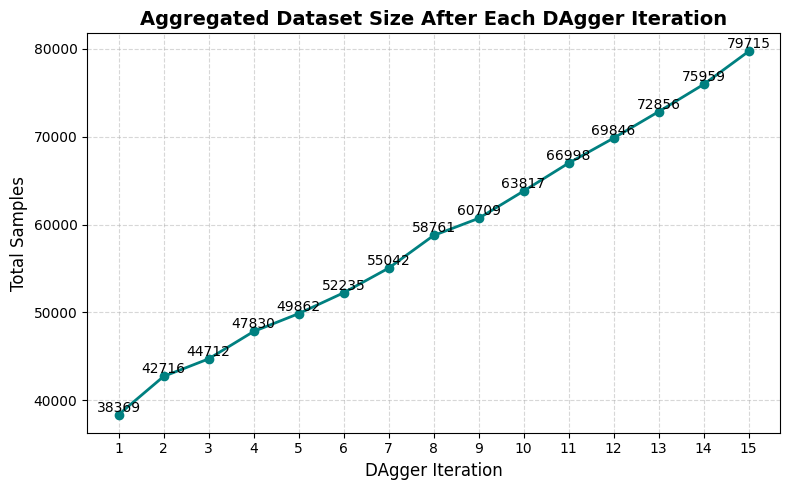

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_dagger_iterations + 1), dataset_sizes, marker='o', color='teal', linewidth=2)
for i, size in enumerate(dataset_sizes):
    plt.text(i + 1, size, str(size), ha='center', va='bottom', fontsize=10)

plt.title("Aggregated Dataset Size After Each DAgger Iteration", fontsize=14, weight='bold')
plt.xlabel("DAgger Iteration", fontsize=12)
plt.ylabel("Total Samples", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, n_dagger_iterations + 1))
plt.tight_layout()
plt.show()

## 7. Self-Play with Previous Versions

Further improve the model through self-play reinforcement learning.

Starting enhanced self-play training...
Loaded 5 previous model versions
Added expert model to competitors
Loaded latest DAgger model as starting point


Expert Demo Collection:   0%|          | 0/20 [00:00<?, ?it/s]

Initial performance: 259.79

Iteration 1/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-3


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 11453 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.5874, Imitation Loss: 0.1373, Divergence: 0.3237, Safety: 138.2509, Entropy: -0.0024
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 264.48 vs 282.19
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 261.26 vs 274.99
  vs DAgger-3: Win Rate: 0.67, Avg Reward: 262.24 vs 262.36
Environment performance: 261.53 (best: 259.79)
  Saved improved model with reward 261.53

Iteration 2/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 23349 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.5007, Imitation Loss: 0.1851, Divergence: 0.1231, Safety: 78.3048, Entropy: -0.0027
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 247.89 vs 271.83
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 256.23 vs 230.56
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 250.51 vs 268.31
Environment performance: 252.89 (best: 261.53)

Iteration 3/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 37248 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.5135, Imitation Loss: 0.2144, Divergence: 0.0505, Safety: 25.2832, Entropy: -0.0028
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 217.86 vs 259.14
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 229.85 vs 254.37
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 290.86 vs 307.74
Environment performance: 246.64 (best: 261.53)

Iteration 4/50
Competing against: Expert
Competing against: DAgger-4
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 52111 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4985, Imitation Loss: 0.2203, Divergence: 0.0276, Safety: 24.3616, Entropy: -0.0029
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 236.97 vs 264.37
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 234.04 vs 254.62
  vs DAgger-1: Win Rate: 0.33, Avg Reward: 235.61 vs 254.69
Environment performance: 253.14 (best: 261.53)

Iteration 5/50
Competing against: Expert
Competing against: DAgger-3
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 67688 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4751, Imitation Loss: 0.2283, Divergence: 0.0130, Safety: 24.2830, Entropy: -0.0031
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 239.40 vs 239.93
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 261.88 vs 269.68
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 229.28 vs 265.83
Environment performance: 215.80 (best: 261.53)

Iteration 6/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 83431 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4594, Imitation Loss: 0.2098, Divergence: 0.0077, Safety: 0.0000, Entropy: -0.0034
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 256.36 vs 273.48
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 217.69 vs 258.94
  vs DAgger-5: Win Rate: 0.00, Avg Reward: 245.53 vs 280.64
Environment performance: 255.41 (best: 261.53)

Iteration 7/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 97900 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4528, Imitation Loss: 0.2078, Divergence: 0.0069, Safety: 0.0000, Entropy: -0.0036
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 282.96 vs 204.25
  vs DAgger-1: Win Rate: 0.33, Avg Reward: 200.68 vs 182.47
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 226.66 vs 219.68
Environment performance: 230.67 (best: 261.53)

Iteration 8/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2872, Imitation Loss: 0.1999, Divergence: 0.0074, Safety: 0.0000, Entropy: -0.0039
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 244.75 vs 277.40
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 235.98 vs 256.91
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 260.03 vs 244.45
Environment performance: 234.43 (best: 261.53)

Iteration 9/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2427, Imitation Loss: 0.1949, Divergence: 0.0063, Safety: 0.0000, Entropy: -0.0042
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 237.51 vs 269.26
  vs DAgger-1: Win Rate: 0.33, Avg Reward: 231.15 vs 223.93
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 216.08 vs 261.37
Environment performance: 259.10 (best: 261.53)

Iteration 10/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.1966, Imitation Loss: 0.1981, Divergence: 0.0077, Safety: 0.0000, Entropy: -0.0045
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 234.49 vs 274.29
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 260.18 vs 287.46
  vs DAgger-5: Win Rate: 0.00, Avg Reward: 237.02 vs 270.38
Environment performance: 261.78 (best: 261.53)
  Saved improved model with reward 261.78
Added model version SelfPlay-10 to competitor pool

Iteration 11/50
Competing against: Expert
Competing against: DAgger-3
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.1378, Imitation Loss: 0.1983, Divergence: 0.0082, Safety: 0.0000, Entropy: -0.0047
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 266.68 vs 292.95
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 251.47 vs 280.66
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 235.96 vs 266.58
Environment performance: 167.27 (best: 261.78)

Iteration 12/50
Competing against: Expert
Competing against: DAgger-3
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2478, Imitation Loss: 0.1918, Divergence: 0.0073, Safety: 261.4947, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 251.23 vs 272.15
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 216.41 vs 256.43
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 225.32 vs 265.39
Environment performance: 131.83 (best: 261.78)

Iteration 13/50
Competing against: Expert
Competing against: DAgger-4
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2422, Imitation Loss: 0.1799, Divergence: 0.0094, Safety: 313.1210, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 261.36 vs 283.97
  vs DAgger-4: Win Rate: 0.33, Avg Reward: 186.06 vs 227.55
  vs SelfPlay-10: Win Rate: 1.00, Avg Reward: 284.21 vs 276.49
Environment performance: 227.21 (best: 261.78)

Iteration 14/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2119, Imitation Loss: 0.2104, Divergence: 0.0071, Safety: 1193.6318, Entropy: -0.0050
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 65.47 vs 261.18
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 254.53 vs 250.50
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 244.27 vs 219.07
Environment performance: 242.21 (best: 261.78)

Iteration 15/50
Competing against: Expert
Competing against: DAgger-3
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.3531, Imitation Loss: 0.1855, Divergence: 0.0089, Safety: 799.0689, Entropy: -0.0050
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 262.15 vs 274.60
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 226.59 vs 260.39
  vs SelfPlay-10: Win Rate: 0.67, Avg Reward: 236.40 vs 225.18
Environment performance: 256.56 (best: 261.78)

Iteration 16/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4454, Imitation Loss: 0.1998, Divergence: 0.0106, Safety: 1653.7767, Entropy: -0.0050
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 215.60 vs 262.62
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 245.46 vs 272.67
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 222.81 vs 255.71
Environment performance: 226.90 (best: 261.78)

Iteration 17/50
Competing against: Expert
Competing against: DAgger-5
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4231, Imitation Loss: 0.2055, Divergence: 0.0076, Safety: 1125.3281, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 220.99 vs 271.88
  vs DAgger-5: Win Rate: 0.00, Avg Reward: 134.47 vs 268.54
  vs SelfPlay-10: Win Rate: 1.00, Avg Reward: 254.73 vs 233.52
Environment performance: 198.00 (best: 261.78)

Iteration 18/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-3


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.3709, Imitation Loss: 0.1940, Divergence: 0.0066, Safety: 1187.5512, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 177.83 vs 227.75
  vs DAgger-1: Win Rate: 0.33, Avg Reward: 230.47 vs 259.85
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 177.13 vs 280.21
Environment performance: 225.58 (best: 261.78)

Iteration 19/50
Competing against: Expert
Competing against: DAgger-2
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.3485, Imitation Loss: 0.1985, Divergence: 0.0098, Safety: 2843.3408, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 255.21 vs 231.33
  vs DAgger-2: Win Rate: 1.00, Avg Reward: 282.00 vs 111.37
  vs SelfPlay-10: Win Rate: 0.67, Avg Reward: 218.75 vs 237.15
Environment performance: 250.67 (best: 261.78)

Iteration 20/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4812, Imitation Loss: 0.1940, Divergence: 0.0064, Safety: 1778.2161, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 263.10 vs 267.25
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 172.94 vs 266.10
  vs DAgger-4: Win Rate: 0.33, Avg Reward: 48.47 vs 275.85
Environment performance: 233.40 (best: 261.78)

Iteration 21/50
Competing against: Expert
Competing against: DAgger-1
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.3727, Imitation Loss: 0.1860, Divergence: 0.0066, Safety: 3305.4489, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 240.75 vs 244.28
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 213.51 vs 272.93
  vs SelfPlay-10: Win Rate: 0.67, Avg Reward: 185.29 vs 243.33
Environment performance: 240.69 (best: 261.78)

Iteration 22/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.5676, Imitation Loss: 0.1916, Divergence: 0.0083, Safety: 5221.5914, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 120.80 vs 277.68
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 244.54 vs 269.32
  vs DAgger-4: Win Rate: 0.33, Avg Reward: 211.91 vs 241.35
Environment performance: 269.72 (best: 261.78)
  Saved improved model with reward 269.72
Added model version SelfPlay-22 to competitor pool

Iteration 23/50
Competing against: Expert
Competing against: DAgger-4
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4479, Imitation Loss: 0.1989, Divergence: 0.0081, Safety: 4614.5106, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 245.95 vs 267.20
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 205.07 vs 259.61
  vs DAgger-1: Win Rate: 1.00, Avg Reward: 264.78 vs 220.99
Environment performance: 156.49 (best: 269.72)

Iteration 24/50
Competing against: Expert
Competing against: DAgger-3
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.3670, Imitation Loss: 0.1832, Divergence: 0.0056, Safety: 3726.9069, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 169.42 vs 267.55
  vs DAgger-3: Win Rate: 0.33, Avg Reward: 221.52 vs 279.07
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 152.54 vs 275.61
Environment performance: 243.94 (best: 269.72)

Iteration 25/50
Competing against: Expert
Competing against: DAgger-4
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.4042, Imitation Loss: 0.1789, Divergence: 0.0057, Safety: 4739.6186, Entropy: -0.0049
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 230.32 vs 284.23
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 175.49 vs 263.71
  vs DAgger-5: Win Rate: 0.33, Avg Reward: 226.03 vs 255.65
Environment performance: 209.81 (best: 269.72)

Iteration 26/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2484, Imitation Loss: 0.1846, Divergence: 0.0080, Safety: 3489.6354, Entropy: -0.0050
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 261.08 vs 263.38
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 249.58 vs 266.84
  vs DAgger-2: Win Rate: 0.67, Avg Reward: 261.89 vs 251.71
Environment performance: 246.18 (best: 269.72)

Iteration 27/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-3


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.2422, Imitation Loss: 0.1904, Divergence: 0.0061, Safety: 4960.4069, Entropy: -0.0051
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 262.66 vs 268.41
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 195.34 vs 275.78
  vs DAgger-3: Win Rate: 0.33, Avg Reward: 74.41 vs 250.82
Environment performance: 236.55 (best: 269.72)

Iteration 28/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.0939, Imitation Loss: 0.1731, Divergence: 0.0070, Safety: 3203.8691, Entropy: -0.0052
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 213.83 vs 271.59
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 224.44 vs 171.31
  vs DAgger-5: Win Rate: 0.00, Avg Reward: 146.11 vs 292.78
Environment performance: 54.41 (best: 269.72)

Iteration 29/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9870, Imitation Loss: 0.1877, Divergence: 0.0047, Safety: 1990.1703, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 268.66 vs 273.33
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 52.79 vs 266.90
  vs DAgger-4: Win Rate: 0.67, Avg Reward: 189.18 vs 236.31
Environment performance: 211.19 (best: 269.72)

Iteration 30/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.0044, Imitation Loss: 0.1706, Divergence: 0.0040, Safety: 2434.2921, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 205.67 vs 176.78
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 267.42 vs 273.25
  vs DAgger-2: Win Rate: 0.67, Avg Reward: 286.17 vs 187.87
Environment performance: 271.16 (best: 269.72)
  Saved improved model with reward 271.16

Iteration 31/50
Competing against: Expert
Competing against: DAgger-4
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.8926, Imitation Loss: 0.1796, Divergence: 0.0045, Safety: 1520.4410, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 158.44 vs 245.80
  vs DAgger-4: Win Rate: 0.33, Avg Reward: 88.14 vs 237.23
  vs DAgger-5: Win Rate: 0.00, Avg Reward: -7.88 vs 250.06
Environment performance: 251.48 (best: 271.16)

Iteration 32/50
Competing against: Expert
Competing against: SelfPlay-10
Competing against: SelfPlay-22


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.0492, Imitation Loss: 0.1718, Divergence: 0.0048, Safety: 2288.3533, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 279.30 vs 277.31
  vs SelfPlay-10: Win Rate: 0.67, Avg Reward: 250.17 vs 228.80
  vs SelfPlay-22: Win Rate: 0.67, Avg Reward: 217.69 vs 234.87
Environment performance: 259.38 (best: 271.16)

Iteration 33/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.1014, Imitation Loss: 0.1591, Divergence: 0.0050, Safety: 992.0425, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 253.07 vs 227.63
  vs DAgger-2: Win Rate: 0.67, Avg Reward: 275.15 vs 164.01
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 161.27 vs 259.15
Environment performance: 255.00 (best: 271.16)

Iteration 34/50
Competing against: Expert
Competing against: SelfPlay-10
Competing against: SelfPlay-22


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9714, Imitation Loss: 0.1568, Divergence: 0.0061, Safety: 2233.4019, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 236.46 vs 269.27
  vs SelfPlay-10: Win Rate: 1.00, Avg Reward: 270.12 vs 220.54
  vs SelfPlay-22: Win Rate: 0.67, Avg Reward: 236.06 vs 173.98
Environment performance: 232.11 (best: 271.16)

Iteration 35/50
Competing against: Expert
Competing against: SelfPlay-10
Competing against: SelfPlay-22


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.0197, Imitation Loss: 0.1677, Divergence: 0.0036, Safety: 1900.5908, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 266.06 vs 272.52
  vs SelfPlay-10: Win Rate: 0.67, Avg Reward: 271.65 vs 260.84
  vs SelfPlay-22: Win Rate: 0.67, Avg Reward: 224.93 vs 200.41
Environment performance: 244.65 (best: 271.16)

Iteration 36/50
Competing against: Expert
Competing against: DAgger-3
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.0472, Imitation Loss: 0.1621, Divergence: 0.0053, Safety: 1550.1812, Entropy: -0.0052
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 222.22 vs 232.02
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 231.44 vs 267.09
  vs SelfPlay-10: Win Rate: 1.00, Avg Reward: 260.62 vs 244.93
Environment performance: 263.64 (best: 271.16)

Iteration 37/50
Competing against: Expert
Competing against: DAgger-2
Competing against: DAgger-3


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9628, Imitation Loss: 0.1632, Divergence: 0.0037, Safety: 856.4381, Entropy: -0.0052
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 243.27 vs 264.96
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 171.49 vs 284.62
  vs DAgger-3: Win Rate: 0.33, Avg Reward: 243.06 vs 248.86
Environment performance: 234.79 (best: 271.16)

Iteration 38/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 1.1028, Imitation Loss: 0.1638, Divergence: 0.0041, Safety: 1982.7475, Entropy: -0.0051
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 176.06 vs 271.60
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 113.90 vs 267.38
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 279.17 vs 283.46
Environment performance: 227.82 (best: 271.16)

Iteration 39/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9980, Imitation Loss: 0.1578, Divergence: 0.0031, Safety: 1826.5009, Entropy: -0.0051
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 219.98 vs 261.00
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 254.86 vs 216.77
  vs DAgger-2: Win Rate: 0.67, Avg Reward: 271.00 vs 280.57
Environment performance: 129.96 (best: 271.16)

Iteration 40/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9860, Imitation Loss: 0.1776, Divergence: 0.0046, Safety: 1445.5210, Entropy: -0.0052
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 135.12 vs 278.23
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 214.28 vs 273.58
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 87.92 vs 185.67
Environment performance: 269.14 (best: 271.16)

Iteration 41/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9714, Imitation Loss: 0.1610, Divergence: 0.0048, Safety: 1806.4324, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.67, Avg Reward: 277.91 vs 251.43
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 241.04 vs 254.68
  vs DAgger-2: Win Rate: 0.00, Avg Reward: 216.76 vs 282.80
Environment performance: 264.40 (best: 271.16)

Iteration 42/50
Competing against: Expert
Competing against: DAgger-5
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9544, Imitation Loss: 0.1652, Divergence: 0.0032, Safety: 1409.1747, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 205.24 vs 272.80
  vs DAgger-5: Win Rate: 0.33, Avg Reward: 258.99 vs 266.62
  vs SelfPlay-10: Win Rate: 0.33, Avg Reward: 208.06 vs 235.54
Environment performance: 257.17 (best: 271.16)

Iteration 43/50
Competing against: Expert
Competing against: DAgger-2
Competing against: SelfPlay-22


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9798, Imitation Loss: 0.1533, Divergence: 0.0039, Safety: 3029.4021, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 154.82 vs 267.41
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 253.43 vs 226.57
  vs SelfPlay-22: Win Rate: 0.67, Avg Reward: 65.78 vs 89.37
Environment performance: 196.26 (best: 271.16)

Iteration 44/50
Competing against: Expert
Competing against: DAgger-4
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9252, Imitation Loss: 0.1671, Divergence: 0.0056, Safety: 2300.3127, Entropy: -0.0052
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 116.34 vs 301.39
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 178.08 vs 280.60
  vs SelfPlay-10: Win Rate: 0.00, Avg Reward: -106.71 vs 260.96
Environment performance: 255.04 (best: 271.16)

Iteration 45/50
Competing against: Expert
Competing against: DAgger-5
Competing against: SelfPlay-22


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9506, Imitation Loss: 0.1548, Divergence: 0.0056, Safety: 3412.4925, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 221.15 vs 261.75
  vs DAgger-5: Win Rate: 0.33, Avg Reward: 264.02 vs 264.69
  vs SelfPlay-22: Win Rate: 0.67, Avg Reward: 218.04 vs 212.43
Environment performance: 121.56 (best: 271.16)

Iteration 46/50
Competing against: Expert
Competing against: DAgger-3
Competing against: SelfPlay-10


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-10:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9925, Imitation Loss: 0.1631, Divergence: 0.0049, Safety: 3560.1378, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 211.57 vs 271.08
  vs DAgger-3: Win Rate: 0.33, Avg Reward: 192.33 vs 271.51
  vs SelfPlay-10: Win Rate: 1.00, Avg Reward: 268.26 vs 238.70
Environment performance: 266.26 (best: 271.16)

Iteration 47/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-4


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-4:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9520, Imitation Loss: 0.1595, Divergence: 0.0043, Safety: 1904.8873, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 263.03 vs 232.43
  vs DAgger-1: Win Rate: 0.67, Avg Reward: 250.67 vs 243.44
  vs DAgger-4: Win Rate: 0.00, Avg Reward: 176.91 vs 262.96
Environment performance: 219.69 (best: 271.16)

Iteration 48/50
Competing against: Expert
Competing against: DAgger-1
Competing against: DAgger-2


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-2:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9848, Imitation Loss: 0.1560, Divergence: 0.0043, Safety: 3393.7847, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.00, Avg Reward: 49.11 vs 269.55
  vs DAgger-1: Win Rate: 0.00, Avg Reward: 252.16 vs 260.62
  vs DAgger-2: Win Rate: 0.33, Avg Reward: 242.15 vs 215.17
Environment performance: 104.61 (best: 271.16)

Iteration 49/50
Competing against: Expert
Competing against: DAgger-3
Competing against: DAgger-5


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-3:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-5:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9181, Imitation Loss: 0.1538, Divergence: 0.0036, Safety: 2182.3233, Entropy: -0.0053
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 156.97 vs 229.65
  vs DAgger-3: Win Rate: 0.00, Avg Reward: 68.55 vs 264.54
  vs DAgger-5: Win Rate: 0.33, Avg Reward: 68.11 vs 241.67
Environment performance: 184.66 (best: 271.16)

Iteration 50/50
Competing against: Expert
Competing against: SelfPlay-22
Competing against: DAgger-1


Competing vs Expert:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs SelfPlay-22:   0%|          | 0/6 [00:00<?, ?it/s]

Competing vs DAgger-1:   0%|          | 0/6 [00:00<?, ?it/s]

Training on 100000 transitions...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

  RL Loss: 0.9222, Imitation Loss: 0.1559, Divergence: 0.0036, Safety: 2212.6569, Entropy: -0.0054
Evaluating against opponents...
  vs Expert: Win Rate: 0.33, Avg Reward: 95.19 vs 214.64
  vs SelfPlay-22: Win Rate: 0.33, Avg Reward: 194.65 vs 159.08
  vs DAgger-1: Win Rate: 0.33, Avg Reward: 146.97 vs 227.00
Environment performance: 209.05 (best: 271.16)
Self-play training complete! Best reward: 271.16


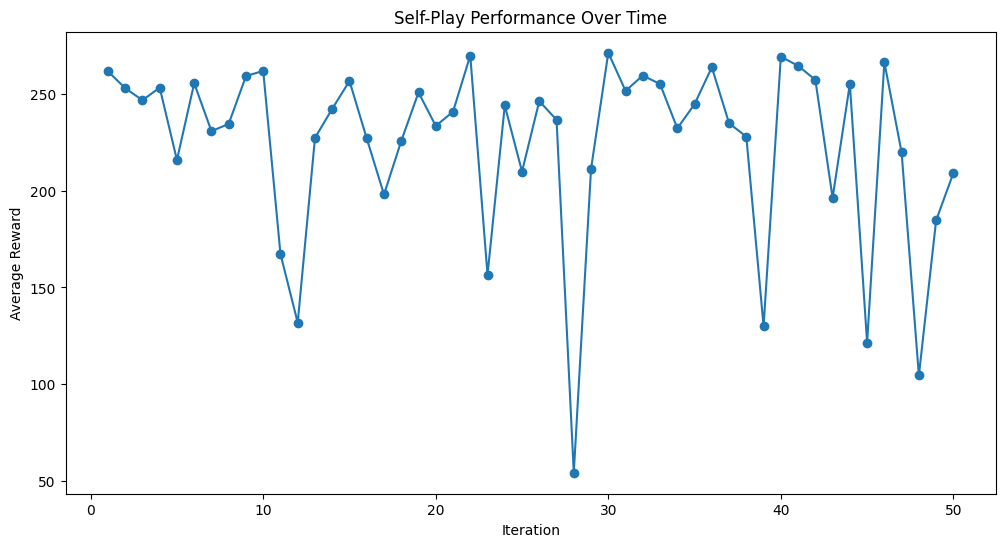

In [ ]:
# Parameters
MEMORY_SIZE = 100000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 0.0001
N_ITERATIONS = 50
EPISODES_PER_ITER = 20
ALPHA = 0.7  # Weight for imitation loss
BETA = 0.2   # Weight for policy divergence
GAMMA_REWARD = 0.1  # Weight for reward optimization

loss_history = []
all_opps = set()

def evaluate_against_opponent(model, opponent_model, env, episodes=5):
    """Evaluate how model performs when competing against an opponent version"""
    model.eval()
    opponent_model.eval()

    # In Lunar Lander single-agent, we simulate "competition" by comparing performance
    # on the same initial states
    total_rewards_model = []
    total_rewards_opponent = []

    for _ in range(episodes):
        # Initialize with same random seed
        seed = random.randint(0, 10000)

        # First let model play
        state, _ = env.reset(seed=seed)
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state

        total_rewards_model.append(total_reward)

        # Then let opponent play same scenario
        state, _ = env.reset(seed=seed)
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = opponent_model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state

        total_rewards_opponent.append(total_reward)

    model.train()
    win_rate = sum(r_m > r_o for r_m, r_o in zip(total_rewards_model, total_rewards_opponent)) / episodes

    return {
        "model_avg": np.mean(total_rewards_model),
        "opponent_avg": np.mean(total_rewards_opponent),
        "win_rate": win_rate
    }


def calculate_competitive_reward(state, next_state, reward, model_action, opponent_action, opponent_type, done):
    # Base environmental reward
    competitive_reward = reward

    # Expert alignment reward (more nuanced than current binary approach)
    if opponent_type == "expert":
        # Graduated reward based on Q-value difference between actions
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = expert_model(state_tensor)[0]
            model_q = q_values[model_action].item()
            expert_q = q_values[opponent_action].item()
            q_diff = expert_q - model_q

            # Scaled reward bonus with diminishing returns
            alignment_bonus = 1.0 if model_action == opponent_action else max(-0.5, -0.1 * min(5.0, abs(q_diff)))
            competitive_reward += alignment_bonus

    # Stability reward - extra reward for keeping lander stable (based on state values)
    if not done:
        # Extract angular velocity from state
        angular_velocity = abs(state[5])
        stability_bonus = 0.2 * (1.0 - min(1.0, angular_velocity/0.5))
        competitive_reward += stability_bonus

    # Landing bonus - large bonus for safe landings
    if done and reward > 100:  # Successful landing
        competitive_reward += 5.0

    return competitive_reward


def select_strategic_opponents(model_versions, best_model, n=3):
    if len(model_versions) <= n:
        return model_versions

    # Always include expert
    expert = next((m for m in model_versions if m["name"] == "Expert"), None)
    selected = [expert] if expert else []

    # Calculate difficulty scores for each opponent
    difficulty_scores = []
    for opponent_info in model_versions:
        if opponent_info in selected:
            continue

        # Run a quick evaluation to see how challenging this opponent is
        results = quick_evaluate_against(best_model, opponent_info["model"], episodes=2)

        # Score based on how close the win rate is to 0.5 (most educational)
        challenge_score = 1.0 - abs(results["win_rate"] - 0.5) * 2.0
        difficulty_scores.append((opponent_info, challenge_score))

    # Select most challenging opponents
    difficulty_scores.sort(key=lambda x: x[1], reverse=True)
    selected.extend([info for info, _ in difficulty_scores[:n-len(selected)]])

    return selected


def evaluate_policy(model, env, episodes=5):
    """Evaluate a policy without exploration"""
    model.eval()
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state
        total_rewards.append(total_reward)
    model.train()
    return np.mean(total_rewards)
def compute_enhanced_composite_loss(state_action_values, expected_values,
                                   logits, expert_actions, prev_logits,
                                   states, next_states, actions,
                                   alpha=0.7, beta=0.2,  
                                   batch_size=128): 
    """Enhanced composite loss with RL, imitation, policy regularization, and safety terms"""

    # 1. RL loss (TD error)
    rl_loss = F.smooth_l1_loss(state_action_values, expected_values)

    # 2. Imitation loss (when expert actions are available)
    imitation_loss = torch.tensor(0.0, device=device)
    if expert_actions is not None:
        expert_logits = logits[batch_size//2:]
        imitation_loss = F.cross_entropy(expert_logits, expert_actions)

    # 3. Policy regularization (KL divergence)
    div_loss = torch.tensor(0.0, device=device)
    if prev_logits is not None:
        log_probs = F.log_softmax(logits, dim=1)
        prev_probs = F.softmax(prev_logits.detach(), dim=1)
        div_loss = F.kl_div(log_probs, prev_probs, reduction='batchmean')

    # 4. NEW: Safety loss - penalize states that lead to crashes - FIX HERE
    safety_loss = torch.tensor(0.0, device=device)
    if next_states is not None:
        # Identify crashes (strongly negative rewards)
        crashes = torch.tensor([r < -50 for r in expected_values], device=device)

        if crashes.any():
            # Extract Q-values for actions that led to crashes
            crash_indices = torch.where(crashes)[0]

            # Fix: Ensure action indices have the right shape and type for gather
            crash_actions = actions[crash_indices]
            if not isinstance(crash_actions, torch.LongTensor) and not isinstance(crash_actions, torch.cuda.LongTensor):
                crash_actions = crash_actions.long()

            # Gather Q-values for the actions that led to crashes
            crash_q_values = logits[crash_indices].gather(1, crash_actions)

            # Strongly penalize these actions
            safety_target = torch.full_like(crash_q_values, -100.0)
            safety_loss = F.mse_loss(crash_q_values, safety_target)

    # 5. Entropy bonus for exploration when not learning from expert
    entropy_loss = torch.tensor(0.0, device=device)
    if expert_actions is None:
        probs = F.softmax(logits, dim=1)
        log_probs = F.log_softmax(logits, dim=1)
        entropy = -(probs * log_probs).sum(dim=1).mean()
        # Negative because we want to maximize entropy (exploration)
        entropy_loss = -0.01 * entropy

    # Combine all losses with weights
    combined_loss = (rl_loss +
                    alpha * imitation_loss +
                    beta * div_loss +
                    0.5 * safety_loss +
                    entropy_loss)

    return combined_loss, {
        'rl': rl_loss.item(),
        'imitation': imitation_loss.item(),
        'divergence': div_loss.item(),
        'safety': safety_loss.item(),
        'entropy': entropy_loss.item()
    }

# Self-play training with multi-generational competition
print("Starting enhanced self-play training...")

# Load different generations of models
model_versions = []
try:
    # Load DAgger models
    for i in range(1, 6):  # Load all 5 DAgger iterations
        model_path = f"models/dagger_model_iter{i}.pth"
        model = DQN(n_observations, n_actions).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()  # Set to evaluation mode
        model_versions.append({"model": model, "name": f"DAgger-{i}"})
    print(f"Loaded {len(model_versions)} previous model versions")

    # Add expert model as another competitor
    expert_model = DQN(n_observations, n_actions).to(device)
    expert_model.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
    expert_model.eval()
    model_versions.append({"model": expert_model, "name": "Expert"})
    print("Added expert model to competitors")
except Exception as e:
    print(f"Couldn't load all model versions: {e}")
    print("Starting with only available models")

# Current best model (student) that we'll continue to improve
best_model = DQN(n_observations, n_actions).to(device)
try:
    best_model.load_state_dict(torch.load("models/dagger_model_iter5.pth", map_location=device))
    print("Loaded latest DAgger model as starting point")
except:
    print("Starting with a fresh model")

# Create target model for stable learning
target_model = DQN(n_observations, n_actions).to(device)
target_model.load_state_dict(best_model.state_dict())
target_model.eval()

# Memory buffers - one standard and one for expert demonstrations
memory = ReplayMemory(MEMORY_SIZE)
expert_memory = ReplayMemory(MEMORY_SIZE // 2)  # Smaller buffer for expert demos

optimizer = optim.Adam(best_model.parameters(), lr=LR)

# Fill expert memory with some expert demonstrations
print("Collecting expert demonstrations...")
expert_model = DQN(n_observations, n_actions).to(device)
expert_model.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
expert_model.eval()

for _ in tqdm(range(20), desc="Expert Demo Collection"):
    state, _ = env.reset()
    done = False

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            action = expert_model(state_tensor).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store expert transition
        expert_memory.push(
            state,
            action,
            next_state if not done else None,
            reward,
            done
        )

        state = next_state

# Performance tracker
performance_history = []
best_reward = evaluate_policy(best_model, env)
print(f"Initial performance: {best_reward:.2f}")

# Create model history folder
os.makedirs("models/competition_history", exist_ok=True)

# Main training loop
for iteration in range(N_ITERATIONS):
    print(f"\nIteration {iteration+1}/{N_ITERATIONS}")

    # Use strategic opponent selection instead of random sampling
    if model_versions:
        # Define the quick evaluation function used by select_strategic_opponents
        def quick_evaluate_against(model, opponent_model, episodes=2):
            return evaluate_against_opponent(model, opponent_model, env, episodes)

        opponents = select_strategic_opponents(model_versions, best_model, n=3)
        for opponent in opponents:
            print(f"Competing against: {opponent['name']}")
    else:
        opponents = []
        print("No opponent models available")

    # 1. Collect experience through standard self-play
    for episode in tqdm(range(EPISODES_PER_ITER), desc="Collecting experience"):
        state, _ = env.reset()
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Epsilon-greedy action selection (with small epsilon)
            if random.random() < 0.05:  # 5% exploration
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = best_model(state_tensor).argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            memory.push(
                state,
                action,
                next_state if not done else None,
                reward,
                done
            )

            state = next_state

    # 2. Collect experience against opponent models
    for opponent_info in opponents:
        opponent = opponent_info["model"]

        for episode in tqdm(range(max(1, EPISODES_PER_ITER // 3)), desc=f"Competing vs {opponent_info['name']}"):
            state, _ = env.reset()
            # Store previous state and action for comparison
            trajectory = []
            done = False

            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

                # Get action from current model
                with torch.no_grad():
                    model_action = best_model(state_tensor).argmax(dim=1).item()

                # Get action from opponent model
                with torch.no_grad():
                    opponent_action = opponent(state_tensor).argmax(dim=1).item()

                # Execute model's action
                next_state, reward, terminated, truncated, _ = env.step(model_action)
                done = terminated or truncated

                # Calculate "competitive reward" - bonus if model action matches expert
                # This creates a learning signal encouraging better performance
                if opponent == expert_model:
                    competitive_reward = reward + (1.0 if model_action == opponent_action else -0.1)
                else:
                    competitive_reward = reward

                # Store transition with modified reward
                memory.push(
                    state,
                    model_action,
                    next_state if not done else None,
                    competitive_reward,
                    done
                )

                # Store opponent's predicted action for this state
                trajectory.append((state, opponent_action))

                state = next_state

            # After episode terminates, store expert trajectories with higher priority
            if opponent == expert_model:
                for s, a in trajectory:
                    expert_memory.push(
                        s,
                        a,
                        None,  # Don't need next state for imitation
                        0,     # Reward doesn't matter for imitation
                        True   # Done flag doesn't matter for imitation
                    )

    # Save snapshot of current version before training further
    torch.save(best_model.state_dict(), f"models/competition_history/model_iter{iteration+1}_pre.pth")

    # 3. Train on collected experiences with multi-objective loss
    if len(memory) >= BATCH_SIZE:
        print(f"Training on {len(memory)} transitions...")

        # Load previous version for regularization
        prev_model = DQN(n_observations, n_actions).to(device)
        prev_model.load_state_dict(best_model.state_dict())
        prev_model.eval()

        loss_stats = {'rl': [], 'imitation': [], 'divergence': [], 'safety': [], 'entropy': []}

        for step in tqdm(range(500), desc="Training"):  # Train for 500 batches
            # Sometimes include expert demonstrations
            use_expert = (step % 5 == 0) and len(expert_memory) > BATCH_SIZE

            if use_expert:
                # Mix regular and expert transitions
                reg_transitions = memory.sample(BATCH_SIZE // 2)
                exp_transitions = expert_memory.sample(BATCH_SIZE // 2)
                transitions = reg_transitions + exp_transitions
            else:
                transitions = memory.sample(BATCH_SIZE)

            batch = Transition(*zip(*transitions))

            # Process batch data for training
            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device, dtype=torch.bool)

            non_final_next_states = torch.tensor(
                np.array([s for s in batch.next_state if s is not None]),
                dtype=torch.float32, device=device)

            state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
            action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
            reward_batch = torch.tensor(batch.reward, device=device)
            done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

            # Get current Q values
            q_values = best_model(state_batch)
            state_action_values = q_values.gather(1, action_batch)

            # Compute expected Q values with target network
            next_state_values = torch.zeros(BATCH_SIZE, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0]

            expected_state_action_values = (next_state_values * GAMMA * (~done_batch)) + reward_batch

            # Get previous policy logits
            with torch.no_grad():
                prev_logits = prev_model(state_batch)

            # For expert demos, get expert actions for imitation loss
            expert_actions = None
            if use_expert:
                # Only use actions from expert transitions (second half of batch)
                expert_actions = action_batch[BATCH_SIZE//2:].squeeze()

            # Compute the enhanced composite loss
            loss, metrics = compute_enhanced_composite_loss(
                state_action_values,
                expected_state_action_values.unsqueeze(1),
                q_values,
                expert_actions,
                prev_logits,
                state_batch,  # Added state batch parameter
                non_final_next_states if non_final_mask.any() else None,  # Added next states parameter
                action_batch,  # Added actions parameter
                alpha=ALPHA,
                beta=BETA
            )

            # Update loss statistics
            for k, v in metrics.items():
                loss_stats[k].append(v)

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            # Clip gradients to stabilize training
            torch.nn.utils.clip_grad_norm_(best_model.parameters(), 10.0)
            optimizer.step()

            # Soft update target network
            for target_param, local_param in zip(target_model.parameters(), best_model.parameters()):
                target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

            avg_rl = np.mean(loss_stats['rl'])
            avg_imt = np.mean(loss_stats['imitation'])
            avg_div = np.mean(loss_stats['divergence'])
            avg_saf = np.mean(loss_stats['safety'])
            avg_ent = np.mean(loss_stats['entropy'])

            # *** Added: record these averages into loss_history
            loss_history.append({
                'rl': avg_rl,
                'imitation': avg_imt,
                'divergence': avg_div,
                'safety': avg_saf,
                'entropy': avg_ent
            })

        # Print average loss components
        print(f"  RL Loss: {np.mean(loss_stats['rl']):.4f}, " +
              f"Imitation Loss: {np.mean(loss_stats['imitation']):.4f}, " +
              f"Divergence: {np.mean(loss_stats['divergence']):.4f}, " +
              f"Safety: {np.mean(loss_stats['safety']):.4f}, " +
              f"Entropy: {np.mean(loss_stats['entropy']):.4f}")

    # 4. Evaluate against each opponent and against environment
    print("Evaluating against opponents...")
    competition_results = {}
    for opponent_info in opponents:
        name = opponent_info["name"]
        opponent = opponent_info["model"]
        results = evaluate_against_opponent(best_model, opponent, env, episodes=3)
        competition_results[name] = results
        print(f"  vs {name}: Win Rate: {results['win_rate']:.2f}, " +
              f"Avg Reward: {results['model_avg']:.2f} vs {results['opponent_avg']:.2f}")

    # Standard evaluation
    current_reward = evaluate_policy(best_model, env)
    print(f"Environment performance: {current_reward:.2f} (best: {best_reward:.2f})")

    # Track performance
    performance_history.append({
        'iteration': iteration + 1,
        'reward': current_reward,
        'competition': competition_results
    })

    # Save if improved
    if current_reward > best_reward:
        best_reward = current_reward
        torch.save(best_model.state_dict(), f"models/self_play_model_iter{iteration+1}.pth")
        print(f"  Saved improved model with reward {best_reward:.2f}")

        # Add this version to the pool of competitors for future training
        if iteration > 0 and iteration % 3 == 0:  # Add every 3rd improved model
            new_competitor = DQN(n_observations, n_actions).to(device)
            new_competitor.load_state_dict(best_model.state_dict())
            new_competitor.eval()
            model_versions.append({
                "model": new_competitor,
                "name": f"SelfPlay-{iteration+1}"
            })
            print(f"Added model version SelfPlay-{iteration+1} to competitor pool")

for h in performance_history:
    all_opps.update(h['competition'].keys())
opponent_names = sorted(all_opps)

# Save final model
print(f"Self-play training complete! Best reward: {best_reward:.2f}")
torch.save(best_model.state_dict(), "models/enhanced_self_play_best.pth")

# Plot performance over iterations
plt.figure(figsize=(12, 6))
rewards = [p['reward'] for p in performance_history]
plt.plot(range(1, len(rewards)+1), rewards, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.title('Self-Play Performance Over Time')
plt.savefig('self_play_performance.png')
plt.show()

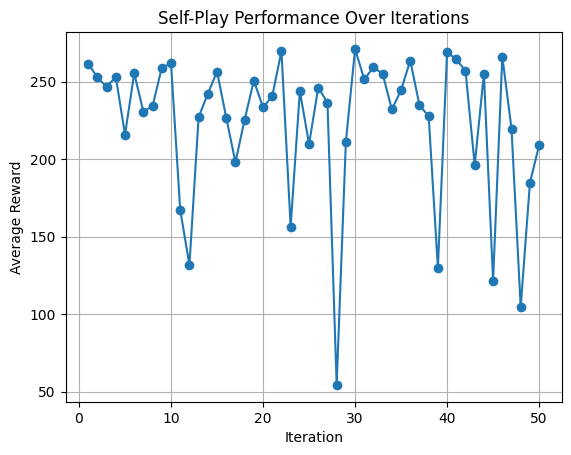

In [31]:
iterations = [h['iteration'] for h in performance_history]
rewards    = [h['reward']    for h in performance_history]

plt.figure()
plt.plot(iterations, rewards, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.title('Self-Play Performance Over Iterations')
plt.grid(True)
plt.show()

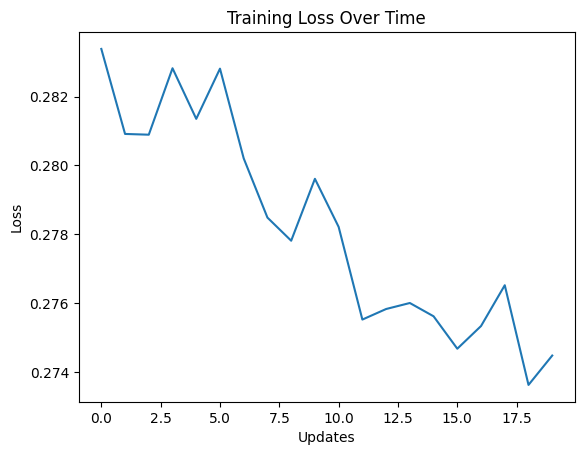

In [32]:
plt.plot(losses)
plt.xlabel('Updates')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

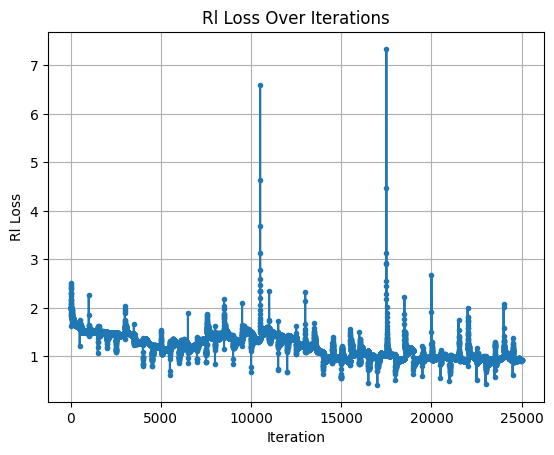

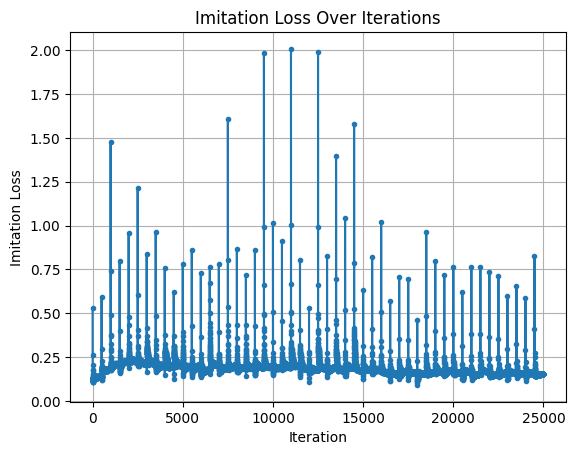

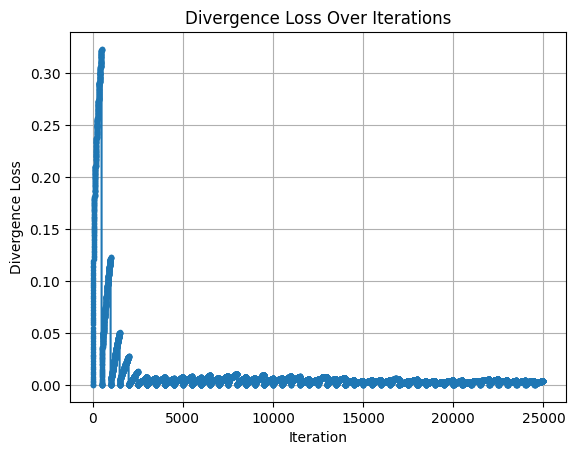

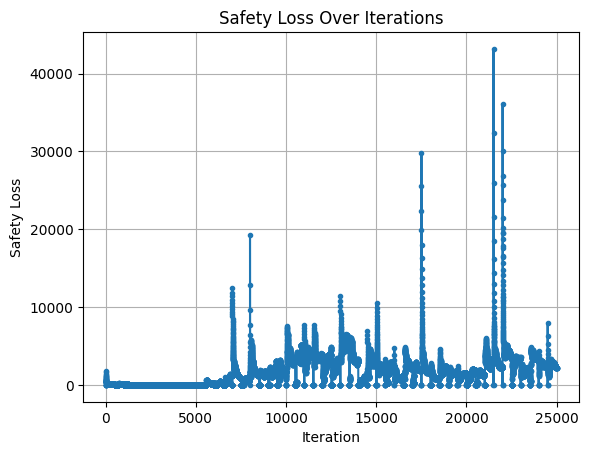

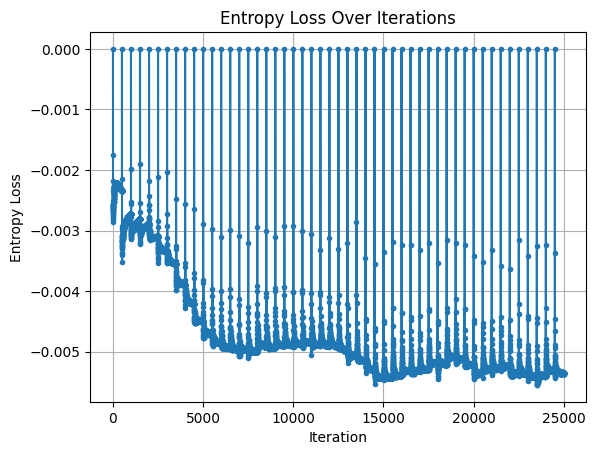

In [49]:
components = ['rl', 'imitation', 'divergence', 'safety', 'entropy']

for comp in components:
    vals = [lh[comp] for lh in loss_history]
    plt.figure()
    plt.plot(range(1, len(vals)+1), vals, marker='.')
    plt.xlabel('Iteration')
    plt.ylabel(f'{comp.capitalize()} Loss')
    plt.title(f'{comp.capitalize()} Loss Over Iterations')
    plt.grid(True)
    plt.show()

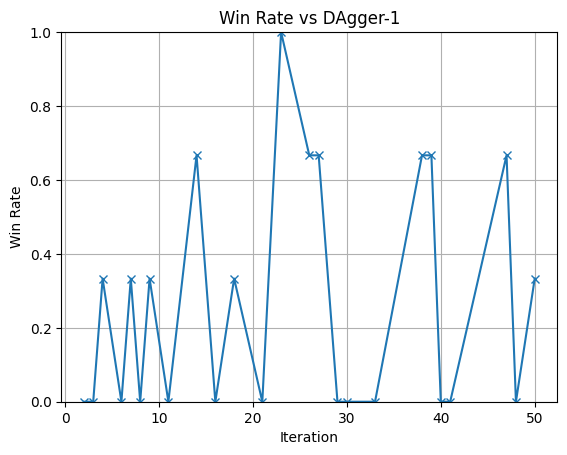

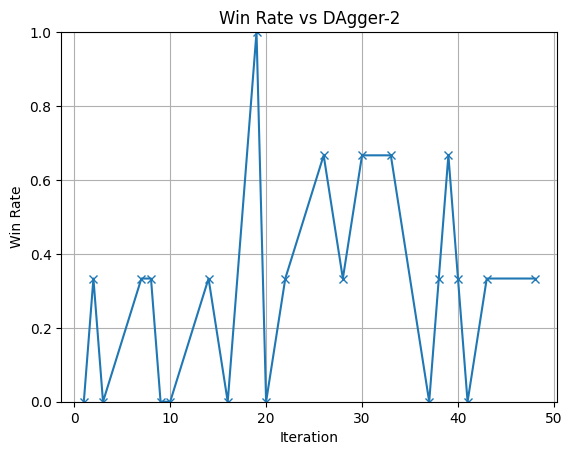

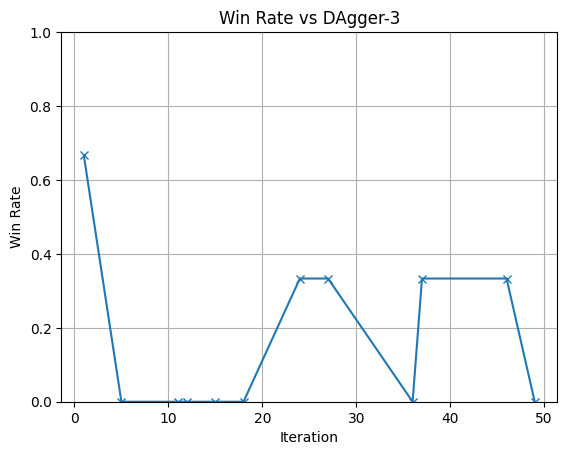

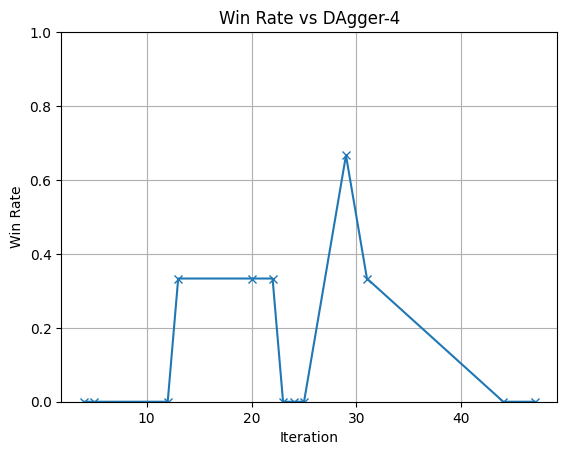

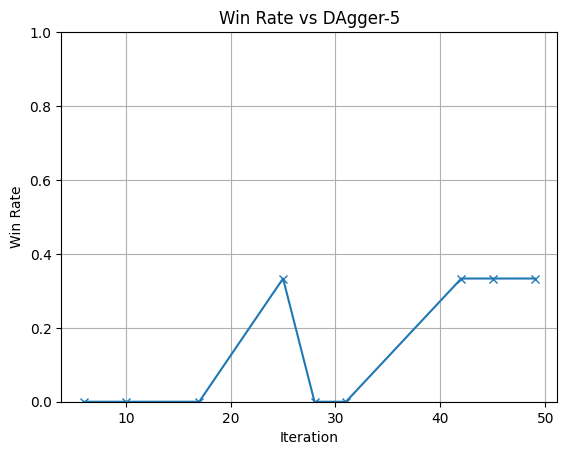

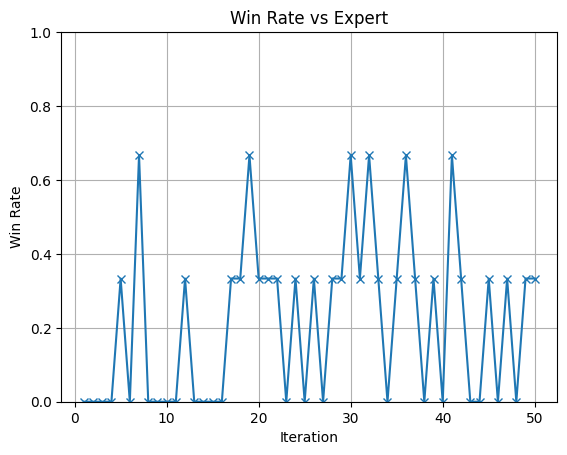

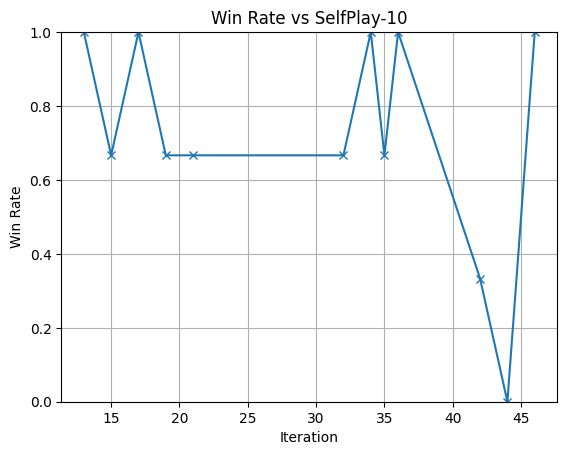

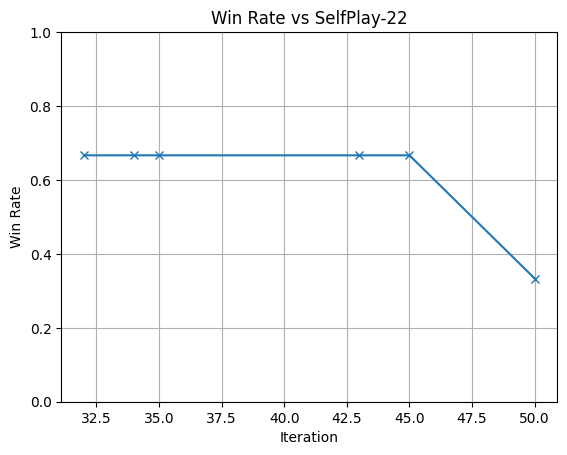

In [34]:
for opp in opponent_names:
    iters, win_rates = [], []
    for h in performance_history:
        if opp in h['competition']:
            iters.append(h['iteration'])
            win_rates.append(h['competition'][opp]['win_rate'])
    if not iters:
        continue

    plt.figure()
    plt.plot(iters, win_rates, marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Win Rate')
    plt.ylim(0, 1)
    plt.title(f'Win Rate vs {opp}')
    plt.grid(True)
    plt.show()

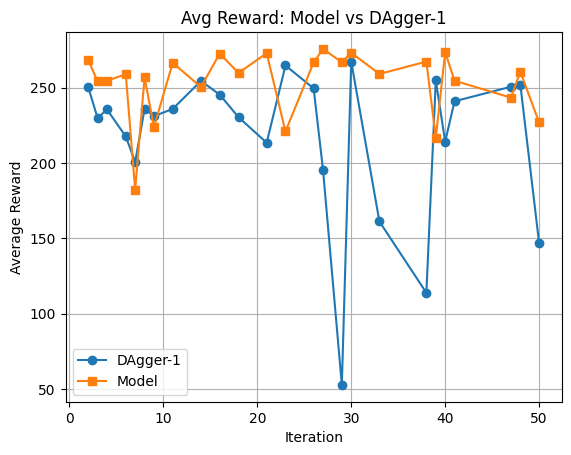

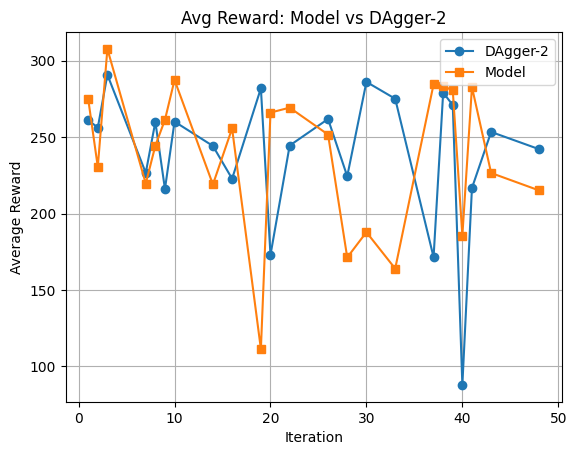

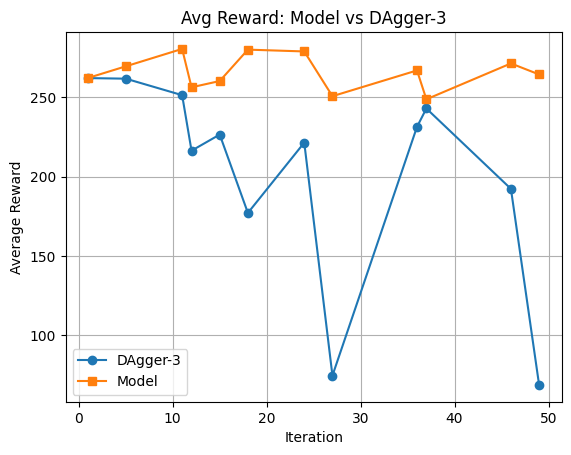

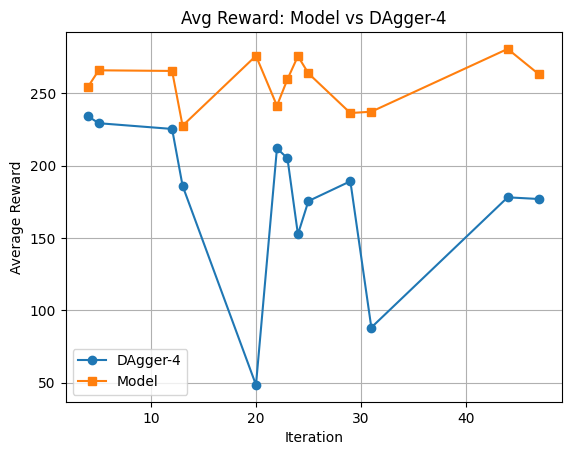

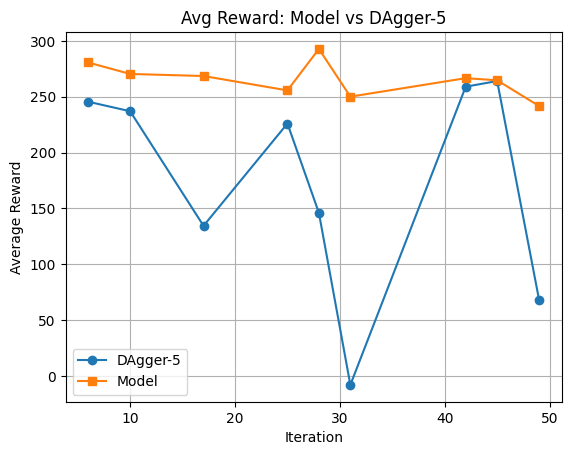

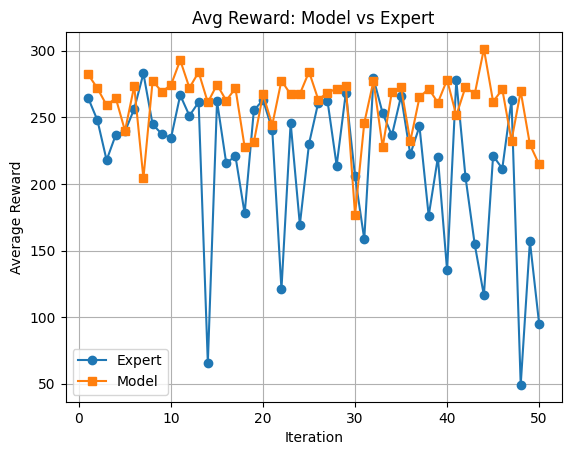

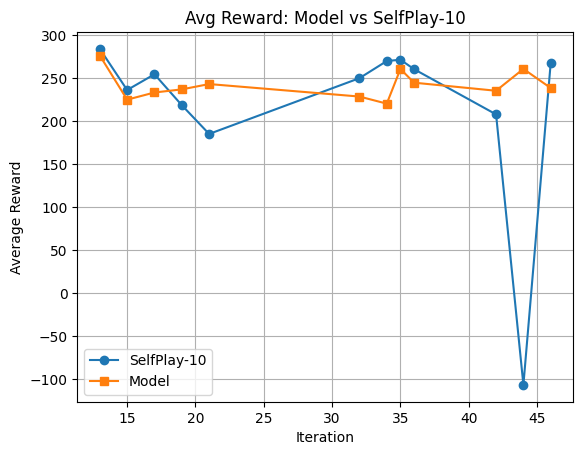

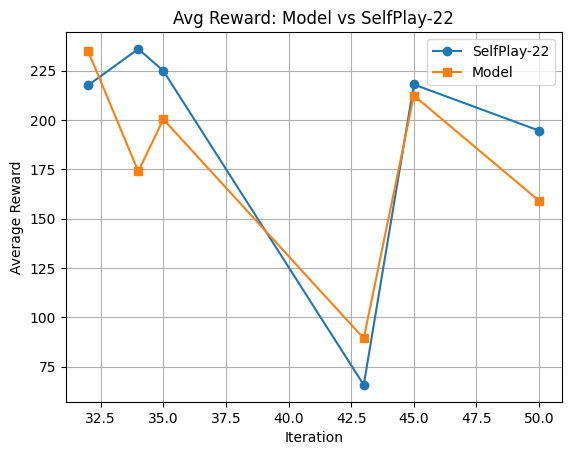

In [45]:
for opp in opponent_names:
    iters, model_avgs, opp_avgs = [], [], []
    for h in performance_history:
        if opp in h['competition']:
            iters.append(h['iteration'])
            model_avgs.append(h['competition'][opp]['model_avg'])
            opp_avgs.append(h['competition'][opp]['opponent_avg'])
    if not iters:
        continue

    plt.figure()
    plt.plot(iters, model_avgs, marker='o', label=opp)
    plt.plot(iters, opp_avgs,   marker='s', label='Model')
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title(f'Avg Reward: Model vs {opp}')
    plt.legend()
    plt.grid(True)
    plt.show()

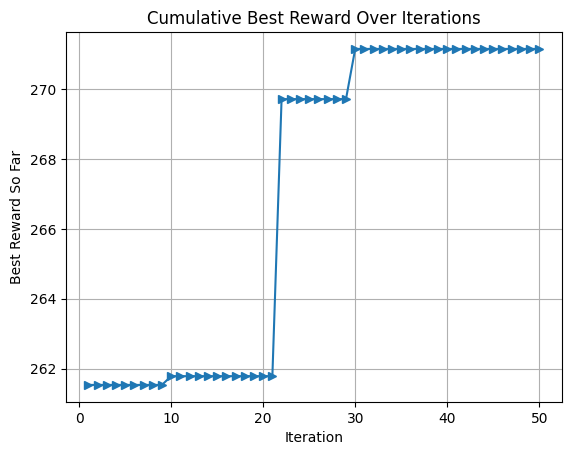

In [37]:
cummax_rewards = np.maximum.accumulate([h['reward'] for h in performance_history])
plt.figure()
plt.plot(iterations, cummax_rewards, marker='>')
plt.xlabel('Iteration')
plt.ylabel('Best Reward So Far')
plt.title('Cumulative Best Reward Over Iterations')
plt.grid(True)
plt.show()

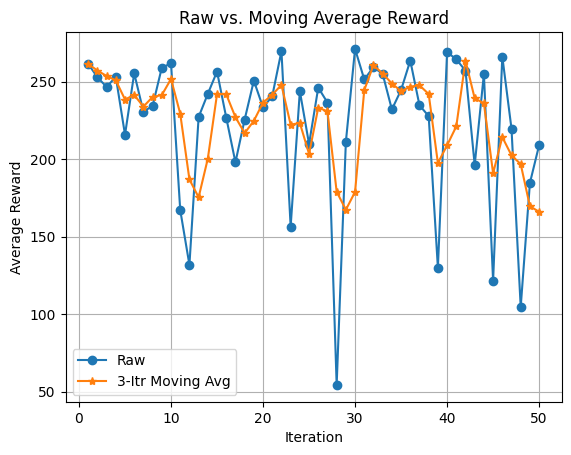

In [38]:
window = 3
rewards = [h['reward'] for h in performance_history]
mov_avg = [np.mean(rewards[max(0, i-window+1):i+1]) for i in range(len(rewards))]

plt.figure()
plt.plot(iterations, rewards,    marker='o', label='Raw')
plt.plot(iterations, mov_avg,    marker='*', label=f'{window}-Itr Moving Avg')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.title('Raw vs. Moving Average Reward')
plt.legend()
plt.grid(True)
plt.show()

## 8. Final Evaluation

Compare all trained models to see which performs best.

In [39]:
# Setup for evaluation
env = gym.make("LunarLander-v3", render_mode="rgb_array")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Load all models to compare
models = {
    "Expert DQN": "models/dqn_lunar_lander.pth",
    "Behavioral Cloning": "models/imitation_model.pth",
    "DAgger": "models/dagger_model_iter5.pth",
    "Enhanced Self-Play": "models/enhanced_self_play_best.pth",
}

# Function to evaluate a model
def evaluate_model_with_render(model_path, n_episodes=10):
    model = DQN(n_observations, n_actions).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    except Exception as e:
        print(f"Failed to load model: {model_path}, error: {e}")
        return []

    rewards = []
    for i in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state

        rewards.append(total_reward)
        print(f"  Episode {i+1}: {total_reward:.2f}")

    return rewards

In [40]:
# Evaluate all models
results = {}
for name, path in models.items():
    try:
        print(f"Evaluating {name}...")
        rewards = evaluate_model_with_render(path)
        results[name] = rewards
        if rewards:  # Only calculate if we got valid rewards
            print(f"  Mean reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

env.close()

Evaluating Expert DQN...
  Episode 1: 288.18
  Episode 2: 302.70
  Episode 3: 281.09
  Episode 4: 272.37
  Episode 5: 304.13
  Episode 6: 288.39
  Episode 7: 265.40
  Episode 8: 263.69
  Episode 9: 258.42
  Episode 10: 281.76
  Mean reward: 280.61 ± 14.96
Evaluating Behavioral Cloning...
  Episode 1: 271.10
  Episode 2: 153.29
  Episode 3: 284.45
  Episode 4: 262.69
  Episode 5: 280.58
  Episode 6: 255.58
  Episode 7: 272.23
  Episode 8: 259.53
  Episode 9: 260.80
  Episode 10: 285.70
  Mean reward: 258.59 ± 36.54
Evaluating DAgger...
  Episode 1: 257.17
  Episode 2: 250.12
  Episode 3: 249.84
  Episode 4: 281.17
  Episode 5: 254.30
  Episode 6: 250.77
  Episode 7: 273.93
  Episode 8: 277.00
  Episode 9: 296.82
  Episode 10: 273.36
  Mean reward: 266.45 ± 15.42
Evaluating Enhanced Self-Play...
  Episode 1: 247.54
  Episode 2: 224.80
  Episode 3: -55.34
  Episode 4: 172.37
  Episode 5: 57.16
  Episode 6: 211.79
  Episode 7: 274.47
  Episode 8: 295.60
  Episode 9: 30.92
  Episode 10: -1.

<ipython-input-41-a5eeb82ccecf>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([valid_models[name] for name in valid_models.keys()], labels=list(valid_models.keys()))


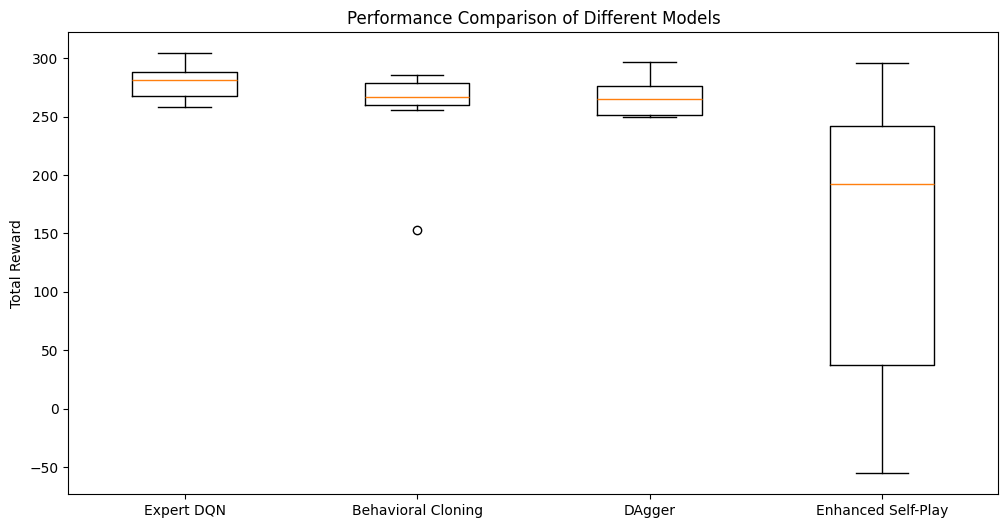


Summary:
Expert DQN: 280.61 ± 14.96
Behavioral Cloning: 258.59 ± 36.54
DAgger: 266.45 ± 15.42
Enhanced Self-Play: 145.80 ± 119.92


In [41]:
# Plot results
plt.figure(figsize=(12, 6))
valid_models = {name: results[name] for name in results if results[name]}
plt.boxplot([valid_models[name] for name in valid_models.keys()], labels=list(valid_models.keys()))
plt.ylabel('Total Reward')
plt.title('Performance Comparison of Different Models')
plt.savefig('model_comparison.png')
plt.show()

# Print summary
print("\nSummary:")
for name in valid_models:
    rewards = valid_models[name]
    print(f"{name}: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

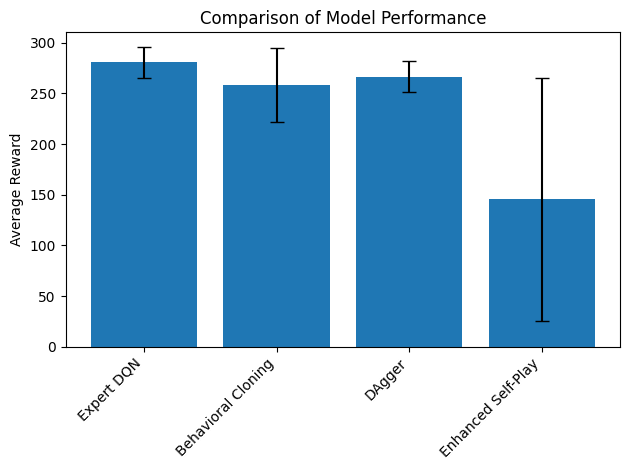

In [42]:
model_names = list(results.keys())
# Compute means and stds
means = [np.mean(results[name]) for name in model_names]
stds  = [np.std(results[name])  for name in model_names]

# 1. Bar chart of mean ± std
plt.figure()
plt.bar(model_names, means, yerr=stds, capsize=5)
plt.ylabel('Average Reward')
plt.title('Comparison of Model Performance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-43-8d3f3387b6f0>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[name] for name in model_names], labels=model_names)


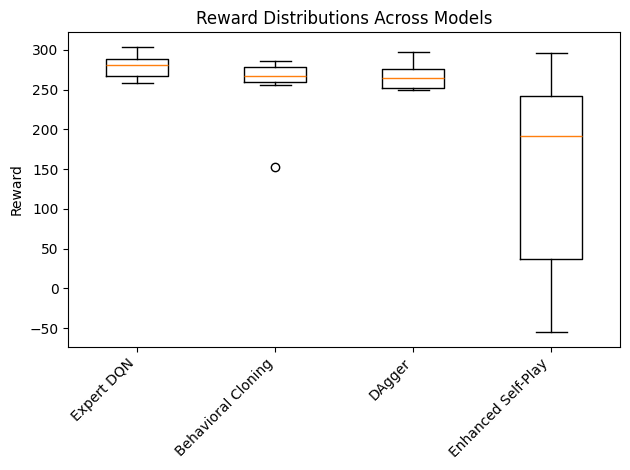

In [43]:
plt.figure()
plt.boxplot([results[name] for name in model_names], labels=model_names)
plt.ylabel('Reward')
plt.title('Reward Distributions Across Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-50-82310383aa07>:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([results[name] for name in model_names], labels=model_names)


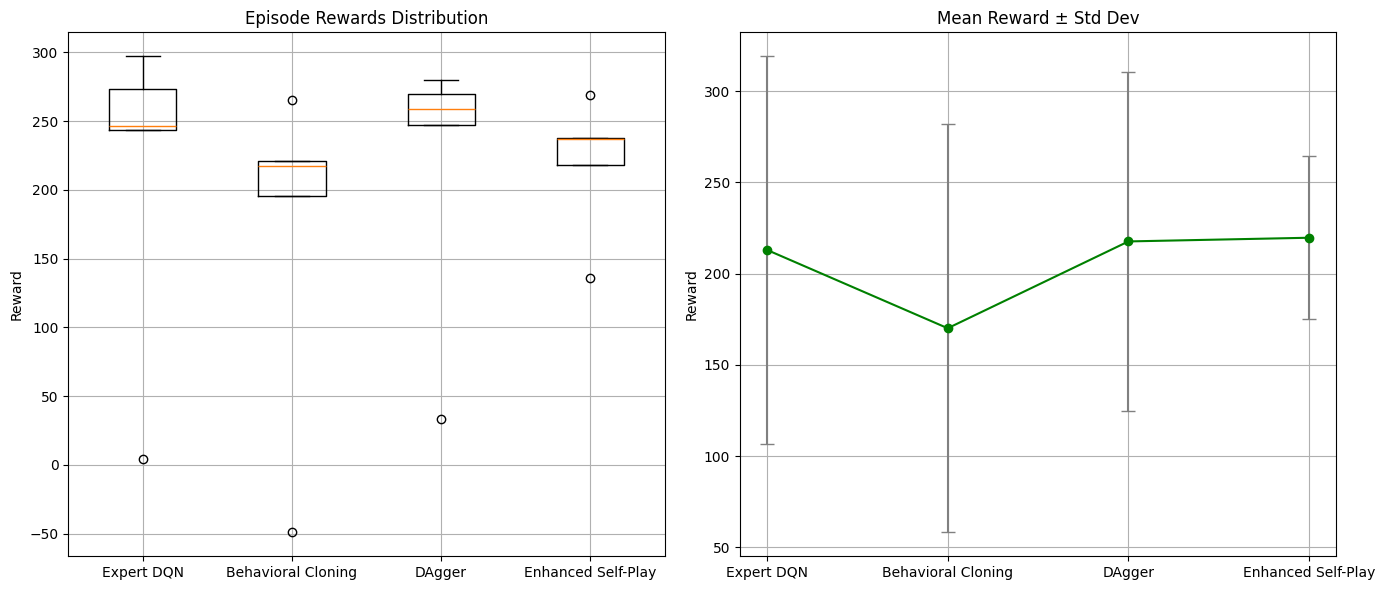

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Raw episode rewards
results = {
    'Expert DQN': [246.73, 273.16, 4.22, 297.25, 243.50],
    'Behavioral Cloning': [-49.14, 195.80, 220.87, 217.47, 265.30],
    'DAgger': [258.48, 269.76, 247.11, 33.14, 279.67],
    'Enhanced Self-Play': [136.21, 218.34, 269.09, 237.00, 237.62]
}

# Compute mean and std
model_names = list(results.keys())
means = [np.mean(results[name]) for name in model_names]
stds = [np.std(results[name]) for name in model_names]

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot of episode rewards
axs[0].boxplot([results[name] for name in model_names], labels=model_names)
axs[0].set_title('Episode Rewards Distribution')
axs[0].set_ylabel('Reward')
axs[0].grid(True)

# Mean ± std plot
axs[1].errorbar(model_names, means, yerr=stds, fmt='o-', capsize=5, color='green', ecolor='gray')
axs[1].set_title('Mean Reward ± Std Dev')
axs[1].set_ylabel('Reward')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('combined_model_performance.png')
plt.show()


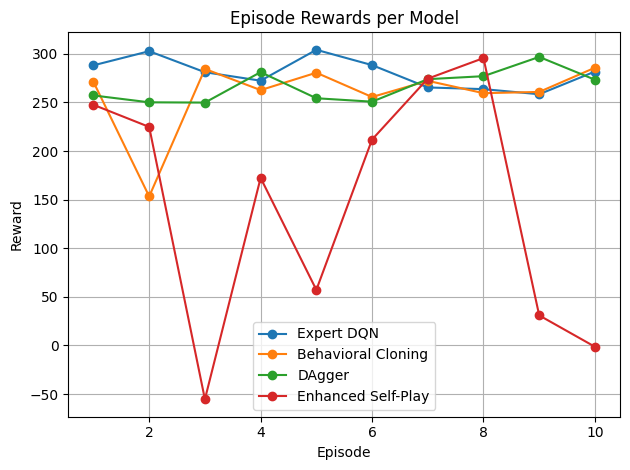

In [44]:
plt.figure()
for name in model_names:
    rewards = results[name]
    plt.plot(range(1, len(rewards)+1), rewards, marker='o', label=name)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards per Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Conclusion

In this notebook, we've implemented a comprehensive reinforcement learning workflow including:

1. Expert DQN training on the LunarLander-v3 environment
2. Generation of expert trajectories from the trained DQN model
3. Behavioral Cloning to create an initial student model from expert demonstrations
4. DAgger (Dataset Aggregation) to improve the student model with additional expert-labeled data
5. Enhanced Self-Play reinforcement learning with multi-agent competition dynamics
   - Competition between different model versions
   - Multi-objective optimization (imitation, competition, and policy regularization)
   - Generation-based model pool for diverse opponents

This combined approach leverages imitation learning (learning from expert demonstrations), reinforcement learning (learning from experience).

Our enhanced self-play mechanism adapted concepts from multi-agent training to a single-agent environment by creating a competitive dynamic between different versions of our policy, leading to more robust performance.